In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic

import matplotlib.pyplot as plt
import arviz as az

Bad val "cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])" on line #240
	"axes.prop_cycle    : cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])  # color cycle for plot lines
"
	in file "C:\Users\zhaolei\.matplotlib\matplotlibrc"
	Key axes.prop_cycle: 'cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])' is not a valid cycler construction: invalid syntax (<string>, line 1)


In [2]:
az.style.use('arviz-darkgrid')

在上一章中，我们了解了Dirichlet过程，这是Dirichlet分布的无穷维概括，可用于在未知连续分布上设置先验。 在本章中，我们将学习高斯过程，它是高斯分布的无穷维概括，可用于在未知函数上设置先验。 贝叶斯统计中使用Dirichlet过程和高斯过程来建立灵活的模型，其中参数的数量随数据的大小而增加。 在本章中，我们将介绍以下主题：

![title](7_1.png)

## Linear models and non-linear data
在此，$ \theta $是用于某些概率分布的参数（例如，高斯的均值），二项式的p参数，泊松分布的速率等等。 我们称$ \psi $为反向链接函数，而$ \Phi $为平方根或多项式函数。 对于简单的线性回归情况，$ \psi $是恒等函数。

拟合（或学习）贝叶斯模型可以看作是找到权重\beta的后验分布，因此，这被称为近似函数的权重视图。 正如我们已经看到的，通过多项式回归示例，通过使$\Phi $为非线性函数，我们可以将输入映射到特征空间上。 然后，我们在特征空间中拟合线性关系，而该线性关系在实际空间中不是线性的。 我们看到通过使用适当次数的多项式，我们可以完美地拟合任何函数。 但是，除非我们应用某种形式的正则化（例如，使用先验分布），否则将导致存储数据的模型，或者换句话说，具有非常差的泛化属性的模型。

高斯过程通过有效地让数据决定函数的复杂性，同时避免或至少使过拟合的机会最小化，为建模任意函数提供了一种有原则的解决方案。 以下各节从非常实际的角度说明高斯过程。 我们避免涵盖围绕它们的几乎所有数学。 有关更正式的解释，请检查第9章“下一步操作”中列出的资源

## Modeling functions 
我们将通过首先描述将函数表示为概率对象的方式来开始对高斯过程的讨论。 我们可以将函数f视为从一组输入x到一组输出y的映射。 因此，我们可以这样写：
y=f(x)表示功能的一种方法是为每个值列出其对应的值。 实际上，您可能还记得这种表示小学阶段职能的方式：
通常，x和y的值将保留在实线上。 因此，我们可以将函数视为成对的（Xi，Yi）值的（潜在）无限和有序列表。 顺序很重要，因为如果我们改组值，我们将获得不同的功能。
函数也可以表示为由的值索引的（可能）无限数组，其重要区别在于x的值不限于整数，而是可以采用实数。

使用这些描述，我们可以用数字表示所需的任何特定功能。 但是，如果我们想概率表示函数呢？ 好吧，我们可以通过让映射具有概率性质来做到这一点。 让我解释一下； 我们可以让每个值是一个随机变量，以给定的均值和方差分布为高斯分布。 这样，我们就不再具有单个特定功能的描述，而是一个分布族的描述。

图7.1显示使用高斯分布样本进行编码的函数并不是那么疯狂或愚蠢，因此我们可能走在正确的轨道上。然而，用于生成图7.1的方法是有限的，并且不够灵活。尽管我们期望实函数具有某种结构或模式，但表达第一个函数的方式不允许我们对数据点之间的任何关系进行编码。实际上，每个点都完全独立于其他点，因为我们只是从一个共同的一维高斯分布中将它们作为10个独立样本来获得。对于第二个功能，我们介绍一些依赖项。 y_i + 1点的平均值是yi值。尽管如此，接下来我们将看到有一种更通用的方法来捕获依赖关系（不仅限于连续的点之间）。

在继续之前，让我停一会儿，问您为什么我们使用高斯而不使用其他概率分布？首先，由于限制了我们与高斯的合作，因此我们不会失去指定不同形状函数的灵活性，因为每个点都可能具有自己的均值和方差；其次，因为从数学的角度来看，与高斯合作非常好。

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]


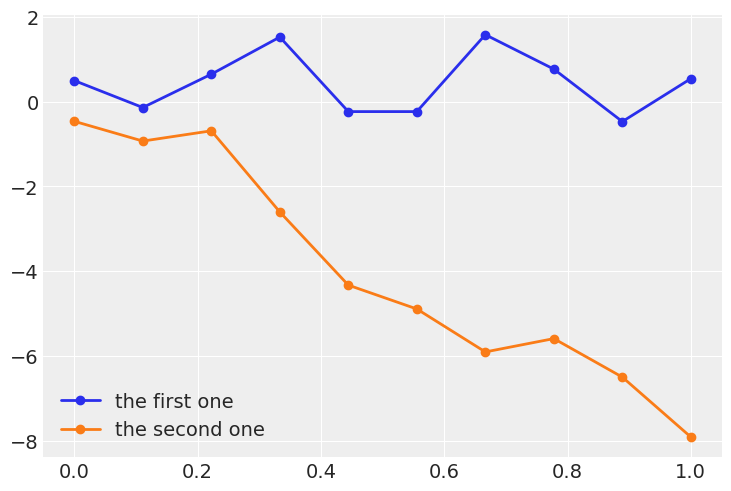

In [3]:
np.random.seed(42)
x = np.linspace(0, 1, 10)

#y = np.random.normal(0, 1, len(x))
#print(y)
y = np.random.multivariate_normal(np.zeros_like(x) ,np.eye(len(x) ) )  #cov, 各个元素的方差是1，且元素间不相关 p=0
print(y)
plt.plot(x, y, 'o-', label='the first one')

y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')

plt.legend()
plt.savefig('B11197_07_01.png')

In [4]:
np.random.seed(42)
print(np.random.normal(0, 1, len(x)))
np.random.seed(42)   #只能生效一次
print(np.random.multivariate_normal(np.zeros_like(x) ,np.eye(len(x) ) ))

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]


In [5]:
np.eye(len(x))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### Multivariate Gaussians and functions
在图7.1中，我们用高斯表示一个函数以获取样本。一种选择是使用多元高斯分布来获取长度为的样本矢量。实际上，您可能希望通过替换来尝试生成如图7.1所示的图形np. random. normal(0, 1, len(x) ) 和 np. random. multivariate_normal(np. zeros_like(x) ,np. eye(len(x) ) )。

您将看到第一个语句与第二个语句等效，但是现在我们可以使用协方差矩阵作为一种方式来编码有关数据点如何相互关联的信息。通过允许协方差矩阵为$ np. eye（len（x））$，我们基本上是说10个点中的每个点的方差均为1，而它们之间的方差（即它们的协方差）为0（因此它们是独立的）。如果将这些零替换为其他（正）数字，则可以得到说不同故事的协方差。因此，要以概率表示函数，我们只需要一个具有合适协方差矩阵的多方高斯函数即可，正如我们在下一部分中将看到的那样。

### Covariance functions and kernels 协方差函数和内核
实际上，协方差矩阵是使用称为内核的函数指定的。 在统计文献中，您可能会发现不止一个内核定义，但数学特性略有不同。 出于讨论的目的，我们要说一个内核基本上是一个对称函数，它接受两个输入并在输入中返回零值，否则相同或为正。 如果满足这些条件，我们可以将内核函数的输出解释为两个输入之间相似性的度量。

![title](7_2.png)

乍一看可能并不明显，但是指数二次方的公式与高斯分布的公式类似（请参见表达式1.3）。 因此，您可能会发现人们将此内核称为高斯内核。 该术语ℓ称为长度尺度（或带宽或方差），它控制内核的宽度。

为了更好地了解内核的作用，让我们定义一个Python函数来计算指数二次方：

核函数K（kernel function）就是指K(x, y) = <f(x), f(y)>，其中x和y是n维的输入值，f(·) 是从n维到m维的映射（通常，m>>n）。<x, y>是x和y的内积（inner product）(也称点积（dot product）)。

令核函数 K(x, y) = (<x, y>)^2.x = (1, 2, 3, 4); y = (5, 6, 7, 8). 那么：K(x, y) = (5+12+21+32)^2 = 70^2 = 4900.

#### kernel其实就是帮我们省去在高维空间里进行繁琐计算的“简便运算法”。甚至，它能解决无限维空间无法计算的问题！因为有时f(·)会把n维空间映射到无限维空间去。

![title](7_8.png)

我们知道，世界上的一切都可以分解为基本要素的组合。 例如，水是氢和氧的混合物。 同样，在数学中，基础用于以简单统一的方式表示各种事物。

在空间中，我们可以使用n个独立的向量通过线性组合表示任何向量。 可以将n个独立向量视为一组基础。 空间中有无限的基础集。 其中，彼此正交的基向量是特别有意义的。 例如，是一个具有相同长度且相互正交的基向量的特殊基集，其中eiei是一个矢量，除第i个条目等于1外，它具有所有零个条目。内积运算符测量矢量之间的相似性。 对于两个向量x和y，内积是一个向量到另一个向量的投影。

![title](7_9.png)

一个函数可以看作是一个无限矢量，然后对于具有两个自变量的函数，我们可以将它视为一个无限矩阵。 其中，如果且对于任何函数，则为对称且为正定的，在这种情况下为核函数。

![title](7_0.png)

#### https://blog.csdn.net/zkq_1986/article/details/52448238

In [6]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

下面的代码和图7.2旨在显示不同输入的4 * 4协方差矩阵的外观。 我选择的输入非常简单，由[-1，0，1，2]值组成。 了解了此示例后，应将其与其他输入一起尝试（请参阅练习1）：

In [7]:
#  def linear_kernel(x, knots):
#      """ linear kernel """
#     return np.array([(x - 2) * (k - 2) for k in knots])

In [10]:
cov

array([[1.        , 0.60653066, 0.13533528, 0.011109  ],
       [0.60653066, 1.        , 0.60653066, 0.13533528],
       [0.13533528, 0.60653066, 1.        , 0.60653066],
       [0.011109  , 0.13533528, 0.60653066, 1.        ]])

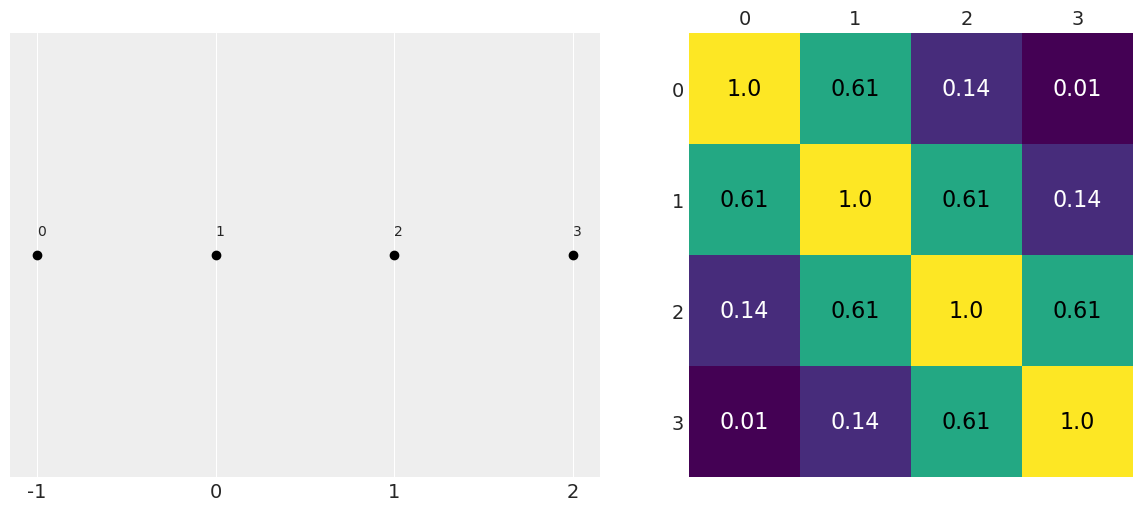

In [9]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()
plt.savefig('B11197_07_02.png')

图7.2左侧的面板显示了输入，x轴上的值表示每个数据点的值，文本注释显示了数据点的顺序（从零开始）。 在右侧面板上，我们有一个热图，表示使用指数二次核获得的协方差矩阵。 颜色越浅意味着协方差越大。 如您所见，热图是对称的，对角线取较大的值。 协方差矩阵中每个元素的值与点之间的距离成反比，因为对角线是每个数据点与其自身比较的结果。 对于该内核，我们获得最接近的距离0和更高的协方差值1。 对于其他内核，其他值也是可能的。(内核正在将数据点沿x轴的距离转换为期望函数值（在y轴上）的协方差值。 因此，最接近的两个点在x轴上 ，我们希望它们的值在y轴上是最相似的。)

总之，到目前为止，我们已经看到可以使用具有给定协方差的多元正态分布来对函数进行建模。 我们可以使用内核函数来构建协方差。 在以下示例中，我们使用exp_quad_kernel函数定义多元正态的协方差矩阵，然后使用该分布中的样本表示函数：

如您在图7.3中所见，高斯内核暗含着各种各样的函数，其参数控制着函数的平滑度。ℓ 的值越大，功能越平滑。

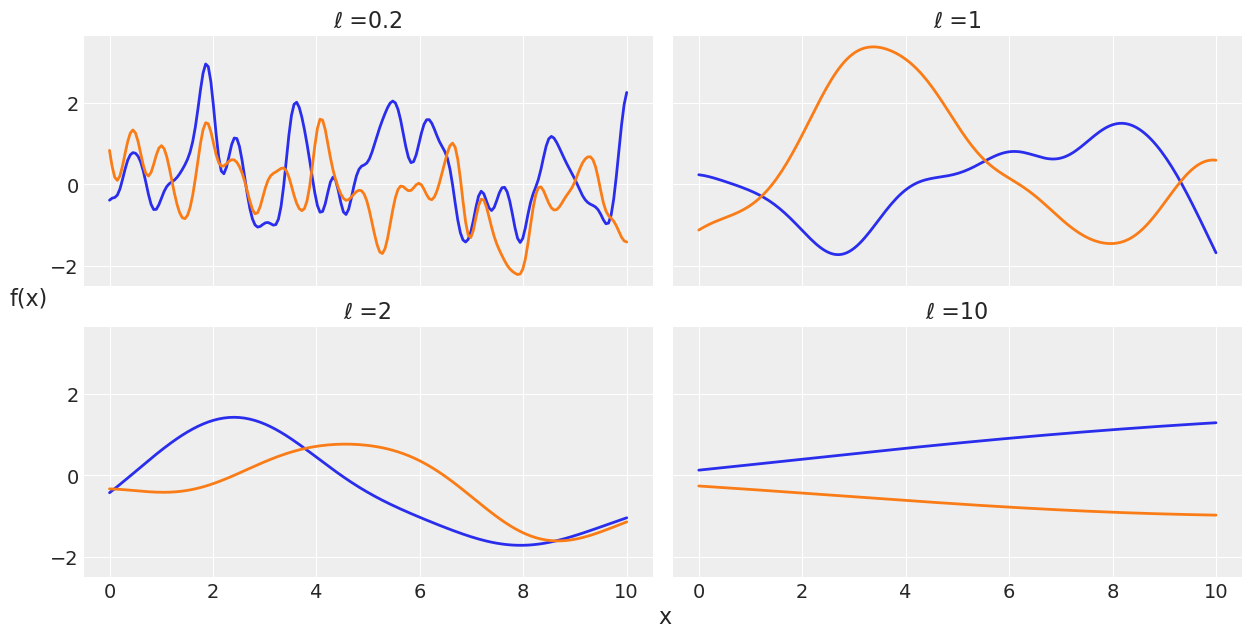

In [11]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)
plt.savefig('B11197_07_03.png')

## Gaussian Process 
#### “按时间或空间索引的随机变量集合，这样这些随机变量的每个有限集合都具有多元正态分布，即它们的每个有限线性组合都是正态分布。”

理解高斯过程的诀窍是要认识到GP的概念是一个心理（和数学）支架，因为在实践中，我们不需要直接处理这个无限的数学对象。 相反，我们仅在我们拥有数据的点评估GP。 通过这样做，我们将无限维GP分解为有限多维高斯分布，其维数与数据点一样多。 从数学上讲，这种崩溃是通过在无限的未观察到的维度上的边缘化来实现的。 理论向我们保证，除了我们正在观察的那些点之外，所有点都可以省略（实际上是边缘化）。 它还保证我们将始终获得多元高斯分布。 因此，我们可以将图7.3严格地解释为来自高斯过程的实际样本！

注意，我们将多元高斯方程的均值设置为零，并通过指数二次核仅使用协方差矩阵对函数建模。 在处理高斯过程时，通常将多元高斯的平均值设置为零。(高斯过程对于构建贝叶斯非参数模型非常有用，因为我们可以将它们用作函数的先验分布。)

## Gaussian Process regression

![title](7_3.png)

x是观测数据点，$x_*$代表测试点； 也就是说，我们想知道推断函数值的新点。
像往常一样，PyMC3允许我们通过照顾我们几乎所有的数学细节来执行推理，高斯过程也不例外。 因此，让我们继续创建一些数据，然后创建一个PyMC3模型：

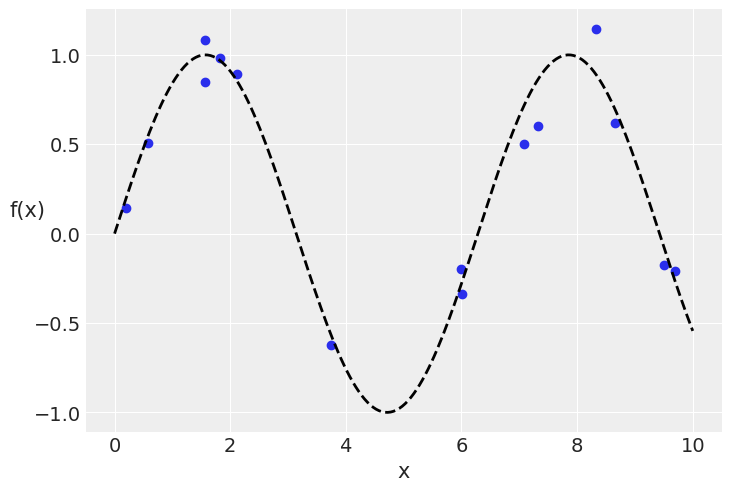

In [12]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)   #y轴字符串同向
plt.savefig('B11197_07_04.png')

In [15]:
print(x)
X = x[:, None]
X.shape

[3.74540119 9.50714306 7.31993942 5.98658484 1.5601864  1.5599452
 0.58083612 8.66176146 6.01115012 7.08072578 0.20584494 9.69909852
 8.32442641 2.12339111 1.81824967]


(15, 1)

在图7.4中，我们将真正的未知函数视为黑色虚线，而点表示未知函数的样本（带有噪声）。

注意，为了将方程式7.7和7.8编码到PyMC3模型中，我们只需要找出参数ϵ，正态似然方差ℓ和指数二次方核的长度尺度参数。

GP在PyMC3中实现为一系列Python类，这些类与我们在先前模型中看到的略有不同。 但是，该代码仍然非常PyMC3onic。 我在以下代码中添加了一些注释，以指导您完成使用PyMC3定义GP的关键步骤：

根据PyMC3的核心开发人员和GP模块的主要贡献者Bill Engels的说法，通常，对于长度比例参数，事先避免零工作会更好。 ℓ的一个有用的默认优先级是pm。 Gamma（2，0. 5）。 您可以从Stan小组阅读有关默认有用先验知识的更多建议：https：// github。 com / stan-dev / stan / wiki / Prior-Choice-Recommendations：

In [16]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    trace_reg = pm.sample(2000,cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 158 seconds.
The acceptance probability does not match the target. It is 0.9083021945449181, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


请注意，我们没有使用表达式7.7预期的正常可能性，而是使用了gp。 marginal_likelihood方法。 您可能从第1章（概率思维）（等式1.1）和第5章（模型比较）（等式5.13）中还记得，边际可能性是可能性和先验概率的积分：

![title](7_4.png)

通常，$\theta$代表所有未知参数，x是自变量，y是因变量。 请注意，我们在函数f的边际化。 对于GP先验概率和正常概率，可以通过分析来执行边缘化。

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


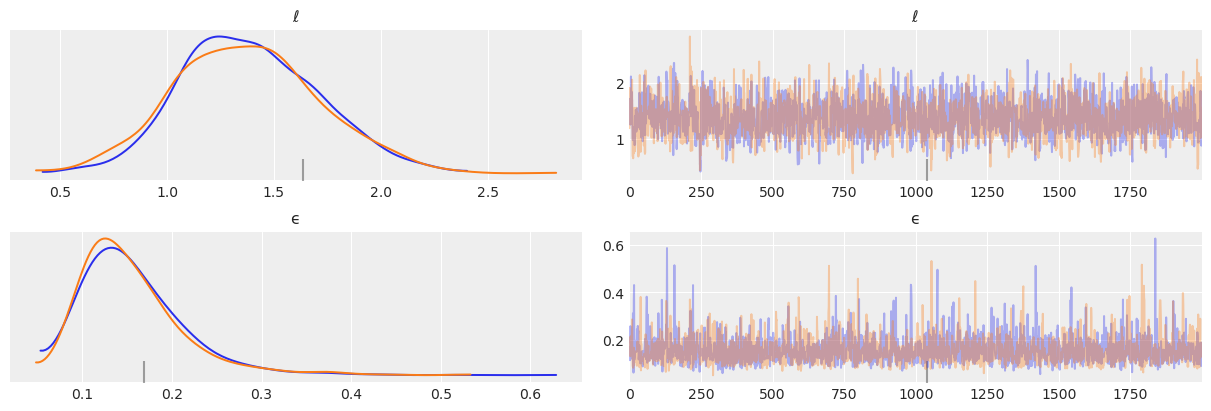

In [17]:
az.plot_trace(trace_reg)
plt.savefig('B11197_07_05.png')

现在我们已经找到了ℓ和ϵ的值，我们可能想从GP后验中获取样本。 也就是说，拟合数据的函数样本。 我们可以使用（gp.conditional函数）通过计算在新输入位置上评估的条件分布来做到这一点：

In [18]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    #del marginal_gp_model.named_vars['f_pred']
    #marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


结果，我们得到一个新的PyMC3随机变量f_pred，我们可以使用它从后验预测分布中获取样本（以X_new值进行评估）：

In [19]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred], samples=82)

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


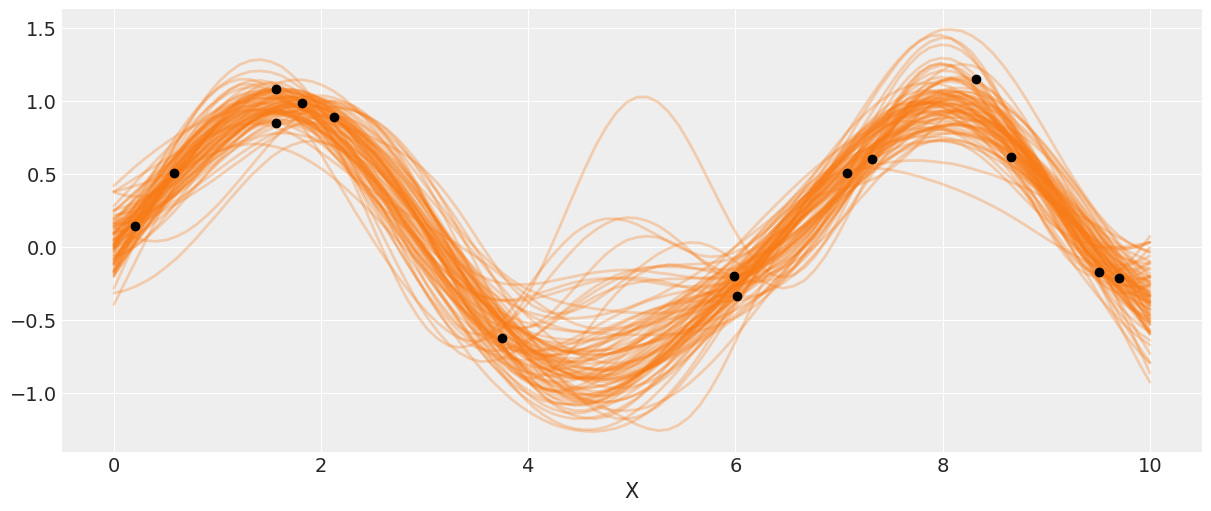

In [20]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('B11197_07_06.png')

pm.gp.util.plot_gp_dist函数可以得到一些漂亮的图。 每个图代表一个百分比，范围从51（较浅的颜色）到99（较暗的颜色）：

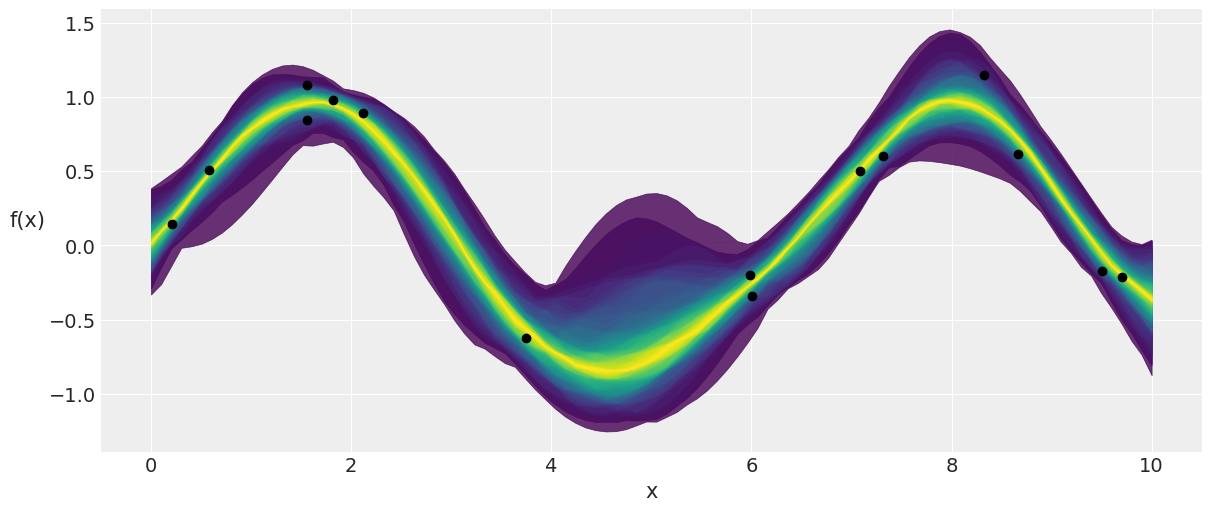

In [22]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette='viridis', plot_samples=False);

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
plt.savefig('B11197_07_07.png')

另一替代方案是计算在参数空间中给定点处评估的条件分布的平均向量和标准偏差。 在以下示例中，我们使用ℓ和ϵ的平均值（在轨迹中的样本上）。 我们可以使用（gp. predict function）计算均值和方差。 我们可以这样做是因为PyMC3已分析计算了后验：

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


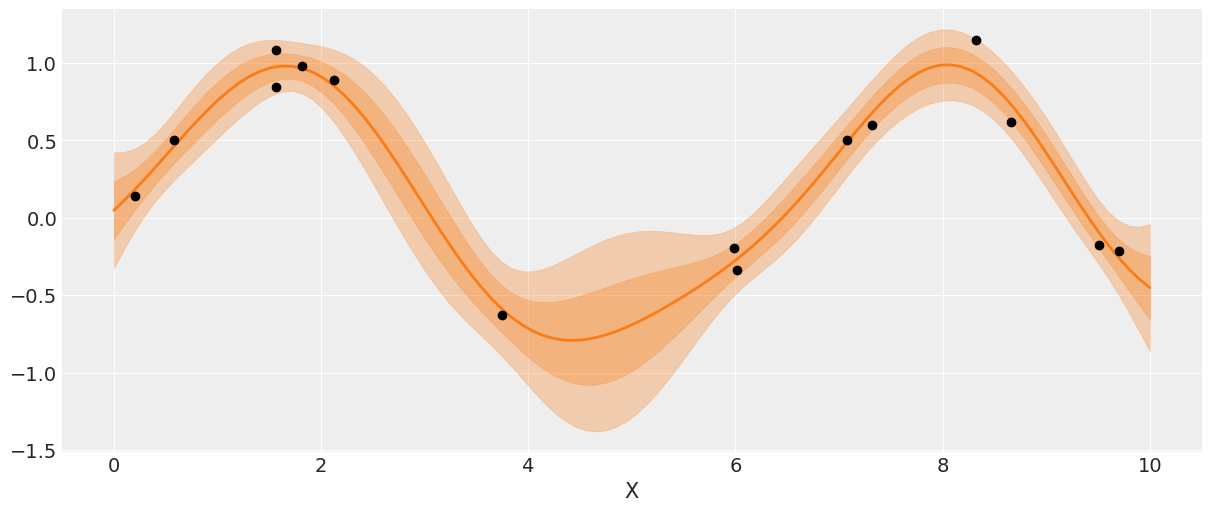

In [23]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
point = {'ℓ': trace_reg['ℓ'].mean(), 'ϵ': trace_reg['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('B11197_07_08.png')

正如我们在第4章“通用线性模型”中所看到的，我们可以使用具有非高斯似然性和适当的逆链接函数的线性模型来扩展线性模型的范围。 我们可以为GP做同样的事情。 例如，我们可以将Poisson似然函数与指数逆链接函数一起使用。 对于这样的模型，后验不再是易分析的，但尽管如此，我们仍可以使用数值方法对其进行近似。 在以下各节中，我们将讨论这种类型的模型。

## Regression with spatial autocorrelation 具有空间自相关的回归
以下示例摘自Richard McElreath撰写的《 Statistical Rethinking》一书。 作者请我在这里重用他的例子。 我强烈建议您阅读他的书，因为您会发现许多像这样的很好的例子和非常好的解释。 唯一需要注意的是，本书的示例均在R / Stan中，但请不要担心，请继续取样；https://github.com/pymc-devs/resources

好了，回到这个例子，我们有10个不同的岛屿社会。 对于每个岛屿社会，我们都有它们使用的工具数量。 一些理论预测，与较小的人群相比，较大的人群会开发和维护更多的工具。 另一个重要因素是人群之间的接触率。由于我们有许多工具作为因变量，因此可以将带有总体的Poisson回归作为自变量。 实际上，我们可以使用总体的对数，因为真正重要的是（根据理论）是总体的数量级而不是绝对大小。 在我们的模型中包括接触率的一种方法是，收集有关这些社会在历史中接触的频率的信息，并创建一个分类变量，例如低/高比率（请参阅岛屿DataFrame中的“接触”列）。 还有一种方法是使用社会之间的距离作为接触率的代理，因为可以合理地假设最接近的社会比远处的社会接触的频率更高。

In [30]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

Ml   Ti   SC   Ya   Fi   Tr   Ch   Mn   To   Ha
Malekula    0.0  0.5  0.6  4.4  1.2  2.0  3.2  2.8  1.9  5.7
Tikopia     0.5  0.0  0.3  4.2  1.2  2.0  2.9  2.7  2.0  5.3
Santa Cruz  0.6  0.3  0.0  3.9  1.6  1.7  2.6  2.4  2.3  5.4
Yap         4.4  4.2  3.9  0.0  5.4  2.5  1.6  1.6  6.1  7.2
Lau Fiji    1.2  1.2  1.6  5.4  0.0  3.2  4.0  3.9  0.8  4.9
Trobriand   2.0  2.0  1.7  2.5  3.2  0.0  1.8  0.8  3.9  6.7
Chuuk       3.2  2.9  2.6  1.6  4.0  1.8  0.0  1.2  4.8  5.8
Manus       2.8  2.7  2.4  1.6  3.9  0.8  1.2  0.0  4.6  6.7
Tonga       1.9  2.0  2.3  6.1  0.8  3.9  4.8  4.6  0.0  5.0
Hawaii      5.7  5.3  5.4  7.2  4.9  6.7  5.8  6.7  5.0  0.0

如您所见，主对角线填充有零。 每个岛屿社会的距离均为零公里。 矩阵也是对称的。 上三角和下三角都具有相同的信息。 这是以下事实的直接结果：A点到B点的距离与B点到A点的距离相同。

In [31]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.head().round(1)

culture  population contact  total_tools  mean_TU   lat    lon  lon2  \
0    Malekula        1100     low           13      3.2 -16.3  167.5 -12.5   
1     Tikopia        1500     low           22      4.7 -12.3  168.8 -11.2   
2  Santa Cruz        3600     low           24      4.0 -10.7  166.0 -14.0   
3         Yap        4791    high           43      5.0   9.5  138.1 -41.9   
4    Lau Fiji        7400    high           33      5.0 -17.7  178.1  -1.9   

   logpop  
0     7.0  
1     7.3  
2     8.2  
3     8.5  
4     8.9

在这里，我们省略了α和β的先验值以及内核的hyperprior.x是对数总数，y是工具总数。 基本上，该模型是具有新颖性的Poisson回归，与第4章“广义线性模型”中的模型相比，线性模型f中的一项来自GP。 为了计算GP的内核，我们将使用距离矩阵islands_dist。 通过这种方式，我们将有效地将技术暴露度的相似性度量纳入（从距离矩阵估算）。 因此，不是假设总数仅仅是一个人口的结果以及一个社会与另一个社会之间独立的结果，而是假设每个社会中工具的数量以其地理区域的函数为模型，

In [32]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [33]:
np.array(x_data).shape

(2, 10, 1)

In [34]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)

    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    trace_islands = pm.sample(1000, tune=1000,cores=1,target_accept=0.9)

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\gp\cov.py:93: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2158 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [35]:
#az.summary(trace_islands, var_names=['α', 'β', 'η', 'ℓ', 'f'])

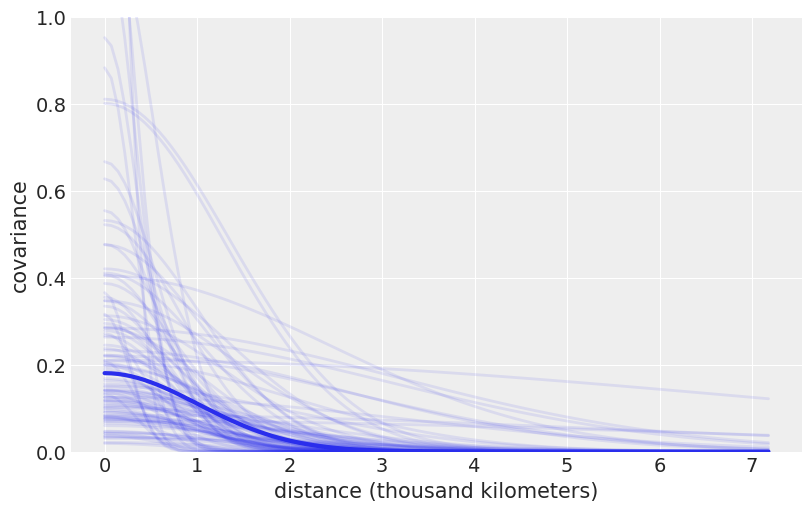

In [56]:
trace_η = trace_islands['η']
trace_ℓ = trace_islands['ℓ']

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_η) *
        np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)

ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] * xrange**2)).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')
plt.savefig('B11197_07_09.png')

In [57]:
point = {'η': trace_islands['η'].mean(), 'ℓ': trace_islands['ℓ'].mean()}
cons = gp.predict(xrange, point=point, diag=True)

NotImplementedError: 

图7.9中的粗线是成对的社会之间协方差的后中值随距离的变化。 我们使用中位数，因为和的分布非常偏斜。 我们可以看到协方差平均没有那么高，并且在大约2,000公里处也下降到几乎为0。 细线表示不确定性，我们可以看到存在很多不确定性。

现在，我们将根据我们的模型探索岛屿社会之间的联系程度。 为此，我们必须将协方差矩阵转换为相关矩阵：

In [49]:
(np.diag(np.diag(Σ)**-0.5)).shape

(10, 10)

In [50]:
Σ.shape

(10, 10)

In [37]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post             #@是一个操作符，表示矩阵-向量乘法;A@x 就是矩阵-向量乘法A*x: np.dot(A, x)
ρ = pd.DataFrame(ρ, index=islands_dist.columns, columns=islands_dist.columns)
ρ.round(2)

Ml    Ti    SC    Ya    Fi    Tr    Ch    Mn    To   Ha
Ml  1.00  0.89  0.82  0.00  0.47  0.13  0.01  0.02  0.18  0.0
Ti  0.89  1.00  0.95  0.00  0.47  0.14  0.02  0.03  0.15  0.0
SC  0.82  0.95  1.00  0.00  0.31  0.24  0.04  0.07  0.08  0.0
Ya  0.00  0.00  0.00  1.00  0.00  0.05  0.30  0.28  0.00  0.0
Fi  0.47  0.47  0.31  0.00  1.00  0.01  0.00  0.00  0.75  0.0
Tr  0.13  0.14  0.24  0.05  0.01  1.00  0.20  0.70  0.00  0.0
Ch  0.01  0.02  0.04  0.30  0.00  0.20  1.00  0.48  0.00  0.0
Mn  0.02  0.03  0.07  0.28  0.00  0.70  0.48  1.00  0.00  0.0
To  0.18  0.15  0.08  0.00  0.75  0.00  0.00  0.00  1.00  0.0
Ha  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0

In [43]:
K=np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
sigma_post = np.sqrt(np.diag(K))
Rho = (sigma_post** -1 ) *  K  *   (sigma_post** -1 ) 

# add row/col names for convenience
Rho = pd.DataFrame(
    Rho,
    index=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
    columns=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
)

Rho.round(2)

Ml    Ti    SC    Ya    Fi    Tr    Ch    Mn    To   Ha
Ml  1.00  0.89  0.82  0.00  0.47  0.13  0.01  0.02  0.18  0.0
Ti  0.89  1.00  0.95  0.00  0.47  0.14  0.02  0.03  0.15  0.0
SC  0.82  0.95  1.00  0.00  0.31  0.24  0.04  0.07  0.08  0.0
Ya  0.00  0.00  0.00  1.00  0.00  0.05  0.30  0.28  0.00  0.0
Fi  0.47  0.47  0.31  0.00  1.00  0.01  0.00  0.00  0.75  0.0
Tr  0.13  0.14  0.24  0.05  0.01  1.00  0.20  0.70  0.00  0.0
Ch  0.01  0.02  0.04  0.30  0.00  0.20  1.00  0.48  0.00  0.0
Mn  0.02  0.03  0.07  0.28  0.00  0.70  0.48  1.00  0.00  0.0
To  0.18  0.15  0.08  0.00  0.75  0.00  0.00  0.00  1.00  0.0
Ha  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0

剩下的两个发现是夏威夷非常寂寞。 这是有道理的，因为夏威夷与其他岛屿社会相距甚远。 此外，我们可以看到，Malekula（Ml），Tikopia（Ti）和Santa Cruz（SC）彼此高度相关。 这也很有意义，因为这些社会之间的联系非常紧密，并且它们的工具数量也差不多。

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


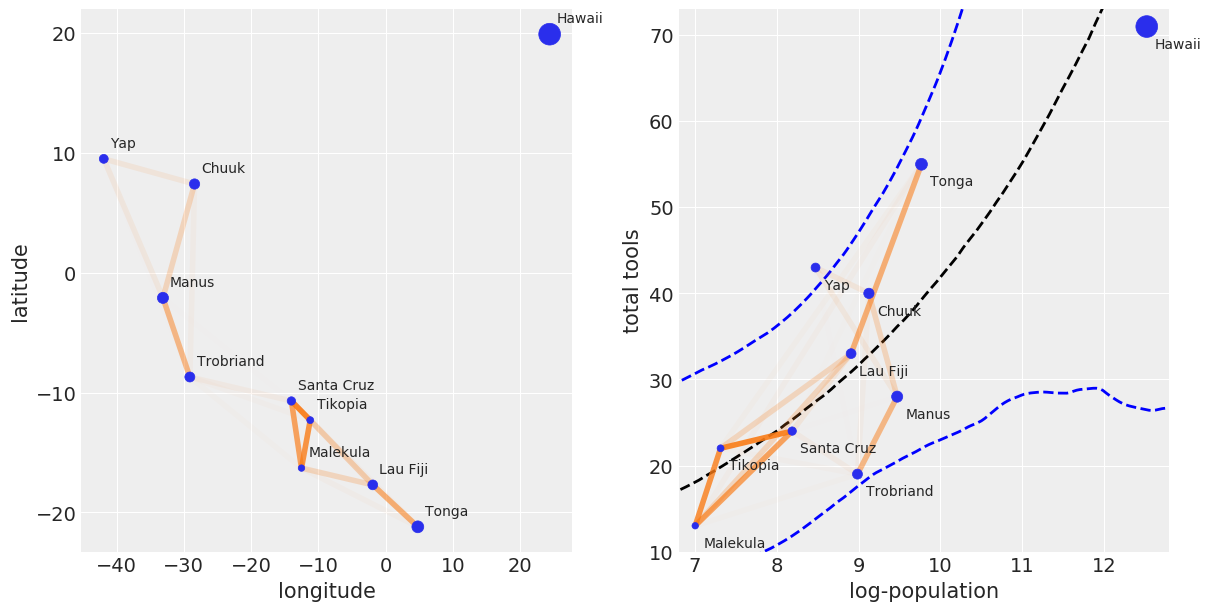

In [60]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(trace_islands['α'][:, None] +
                     trace_islands['β'][:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)  #zorder这个整数越大，显示的时候越靠上
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hpd(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
            plot_kwargs={'color':'b', 'ls':'--', 'alpha':1},ax=ax[1])


for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')


ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)
plt.savefig('B11197_07_10.png')

图7.10的左侧面板显示了我们先前在相对地理位置的背景下在各个社会之间计算的后验中值相关性的线。 由于我们已使用相关性来设置线条的不透明度（使用matplotlib的alpha参数），因此某些线条不可见。 在右侧面板上，我们再次获得了后验中值相关性，但是这次是根据对数人口与工具总数的关系绘制的。 虚线表示工具的中位数和94％的HPD间隔作为对数填充的函数。 在两个面板中，点的大小与每个岛屿社会的人口成正比。

请注意，Malekula，Tikopia和Santa Cruz之间的相关性如何描述这样一个事实，即他们的工具数量很少，接近其中位数或低于其预期的工具数量。 Trobriands和Manus发生了类似的事情。 他们在地理位置上相近，并且工具数量少于预期的人口规模。 汤加拥有比其预期更多的工具，且与斐济的相关性相对较高。 在某种程度上，该模型告诉我们，汤加对Lua Fiji产生了积极影响，增加了工具的总数，并抵消了它对近邻，Malekula，Tikopia和Santa Cruz的影响。

### Gaussian process classification
高斯过程不仅限于回归。 我们也可以使用它们进行分类。 正如我们在第4章“通用线性模型”中所看到的，我们通过使用具有逻辑逆链接函数的伯努利似然（然后将边界决策规则应用于单独的类），将线性模型转变为合适的模型，以对数据进行分类。 我们将尝试为虹膜数据集重述第4章“概括线性模型”中的model_0，这次使用GP而不是线性模型。


In [3]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [4]:
rng = np.random.RandomState(42)
df1 = pd.DataFrame(rng.rand(1000, 3), columns=['A', 'B', 'C'])
result1 = df1[(df1.A < 0.5) & (df1.B < 0.5)]

result2 = pd.eval('df1[(df1.A < 0.5) & (df1.B < 0.5)]')
result3 = df1.query ('A <0.5 and B <0.5')
print(np.allclose(result1, result2)  )
print (np.allclose(result1, result3) )
df1.eval ('A <0.5 and B <0.5')       #注意和前面的不一样。

True
True


0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999     True
Length: 1000, dtype: bool

In [5]:
result1=iris.query('species=="setosa" and sepal_width >=3.8')
result2=pd.eval('iris[(iris.species=="setosa") & (iris.sepal_width >=3.8)]')
np.allclose(result1.sepal_width, result2.sepal_width)   #计算两者每个元素是否相等,当包含文字时会报错，所以我认为加上了一个限制条件

True

#### https://www.jianshu.com/p/caaf201fc5a8    高性能Pandas:eval和query

In [6]:
df = iris.query("species == ('setosa', 'versicolor')")  #使用布尔表达式查询DataFrame的列，也就是按照DataFrame中某列的规则进行过滤操作
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

我们将从最简单的分类问题开始：两个类，setosa和versicolor，只有一个自变量，即萼片长度。 与往常一样，我们将使用数字0和1编码分类变量setosa和versicolor。

For this model, instead of using the pm. gp. Marginal class to instantiate a GP prior, we are going to use the pm. gp. Latent class. 尽管后者更为通用并且可以在任何可能性下使用，但前者仅限于高斯可能性，并且可以利用GP与高斯似然的组合的数学易处理性来提高效率：
gp.Latent类是GP的直接实现。 假定没有附加噪声。 之所以称为“潜在变量”，是因为基础函数值被视为潜在变量。 它具有先验方法和有条件方法。 给定均值和协方差函数

In [7]:
with pm.Model() as model_iris:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ) # Specify the covariance function.
    gp = pm.gp.Latent(cov_func=cov) # Specify the GP.  The default mean function is `Zero`.
    f = gp.prior("f", X=X_1) # Place a GP prior over the function f.
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris = pm.sample(1000, chains=1, compute_convergence_checks=False,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 223 seconds.


Now that we have found the values of ℓ , we may want to get samples from the GP posterior. As we did with the marginal_gp_model , we can also compute the conditional distribution evaluated over a set of new input locations with the help of the gp_conditional function, as shown in the following code:
既然我们已经找到ℓ 的值，我们可能想要从GP后验中获取样本。 就像我们对marginal_gp_model所做的那样，我们还可以借助gp_conditional函数来计算一组新输入位置上评估的条件分布，如以下代码所示：

In [10]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]

with model_iris:
    f_pred1 = gp.conditional('f_pred1', X_new)
    pred_samples = pm.sample_posterior_predictive(
        trace_iris, vars=[f_pred1], samples=1000)

为了显示该模型的结果，我们将创建一个类似于图4.4的图形。 我们将使用以下便利函数直接从f_pred计算边界决策，而不是解析地获取边界决策：

In [11]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]    #找到最接近0.5的元素
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1   #如果大于0.5，那就减一个值，如果小于0.5那就加一个值，这样包含边界的两个点
    if idx1 == len(array1):
        idx1 -= 1
    #print (idx0,idx1,array1[idx0],array1[idx1])
    return (array2[idx0] + array2[idx1]) / 2       #返回x坐标的点。即中点

In [199]:
az.hpd(db,hdi_prob=.95)

array([4.00753769, 5.56030151])

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


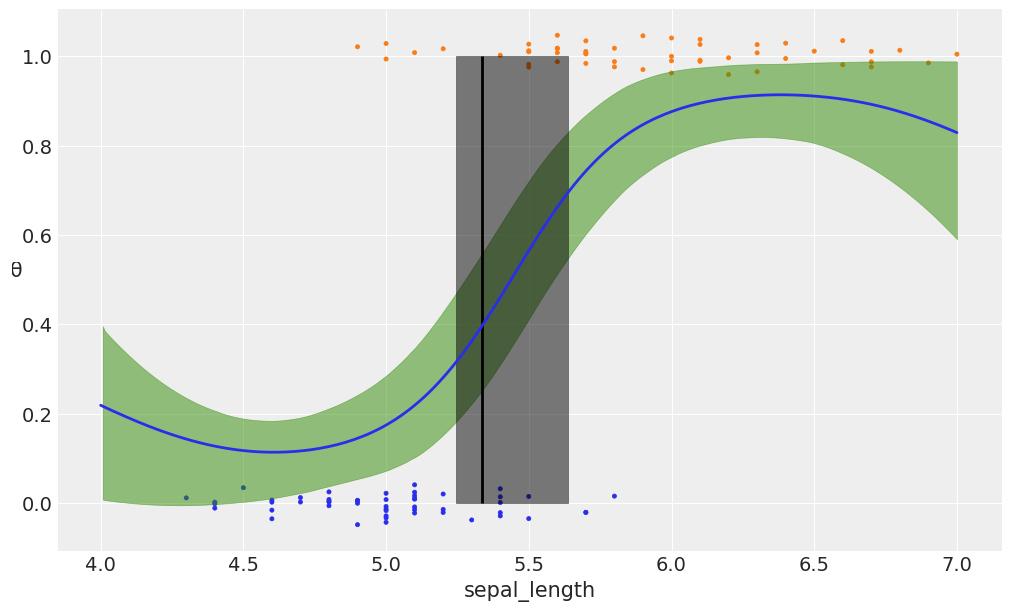

In [14]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred1'])   #from scipy.special import expit as logistic
fp_mean = np.nanmean(fp, 0)         #在我运行的过程中，发现存在nan的值，这样求mean是不行的

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])
fp[np.isnan(fp)]=0   #将空值赋值0.5
az.plot_hpd(X_new[:, 0], fp, color='C2',ax=ax,hdi_prob=.89)

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db,hdi_prob=.89)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_11.png')

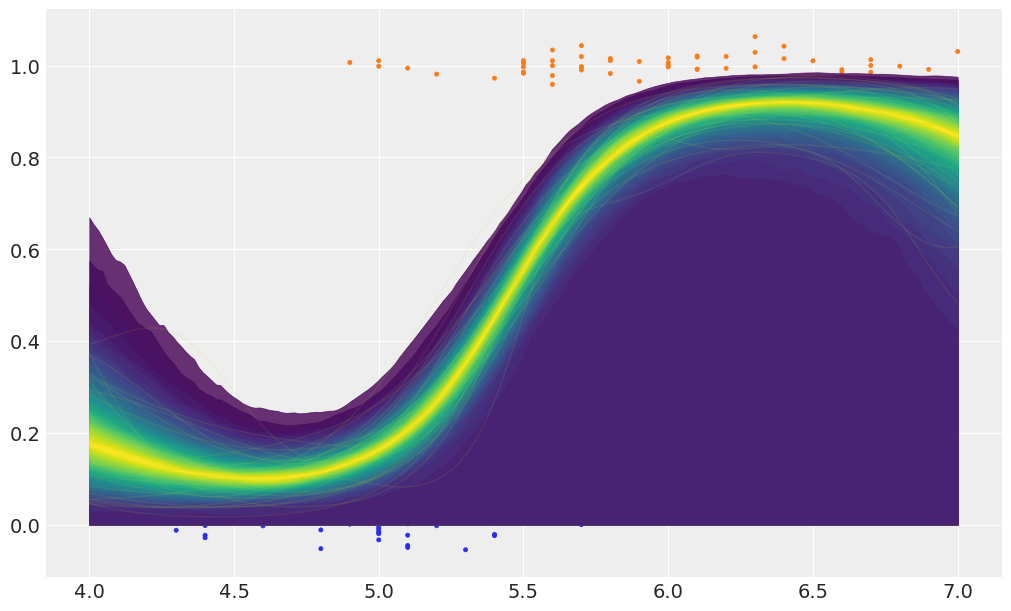

In [16]:
_, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])
fp[np.isnan(fp)]=0
pm.gp.util.plot_gp_dist(ax, fp, X_new[:, 0], palette='viridis', plot_samples=True);

如我们所见，图7.11与图4.4非常相似。 f_pred看起来像是S型曲线，除了尾巴在x_1的较低值处向上和在x_1的较高值处向下时。 这是由于在没有数据（或数据很少）的情况下，预测函数朝着先验的方向移动的结果。 如果只考虑边界决策，这不是一个真正的问题，但是如果要针对sepal_length的不同值建模setosa或versicolor的概率，则应该改进模型并做一些事情来获得 更好的尾巴模型。 实现此目标的一种方法是为高斯过程增加更多的结构。 获取更好的高斯过程模型的一般方法是组合协方差函数，以便更好地捕获我们要建模的函数的细节。

以下模型（model_iris2）与model_iris相同，除了协方差矩阵，我们将其建模为三个内核的组合：

cov = K_{ExpQuad} + K_{Linear} + K_{whitenoise}(1E-5)

通过添加线性核，我们解决了尾部问题，如图7.12所示。 白噪声内核只是稳定协方差矩阵计算的一种计算技巧。 对高斯过程的核进行限制，以确保所得的协方差矩阵为正定。 但是，数值错误可能导致违反此条件。 这个问题的一个体现是，在计算拟合函数的后验预测样本时，我们得到了nans。 减轻此错误的一种方法是通过添加一点噪声来稳定计算。 实际上，PyMC3已经在后台进行了此操作，但是有时需要更多的噪音，如以下代码所示：

In [17]:
with pm.Model() as model_iris2:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris2 = pm.sample(1000, chains=1, compute_convergence_checks=False,cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 329 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples1 = pm.sample_posterior_predictive(trace_iris2,
                                                  vars=[f_pred],
                                                  samples=1000)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


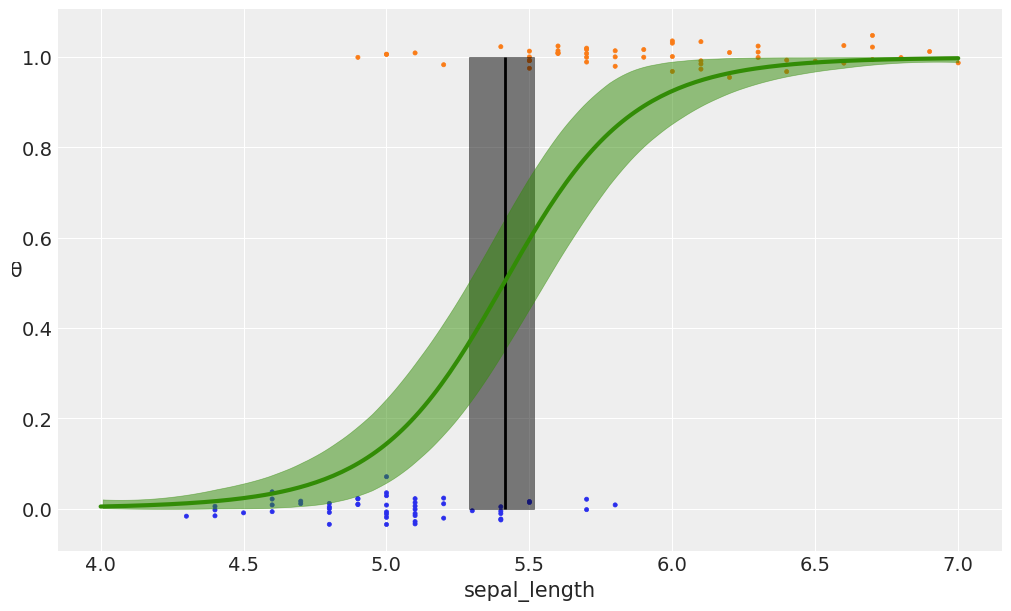

In [19]:

_, ax = plt.subplots(figsize=(10,6))

fp = logistic(pred_samples1['f_pred'])
fp_mean = np.mean(fp, 0)

ax.scatter(x_1, np.random.normal(y, 0.02), marker='.', color=[f'C{ci}' for ci in y])

db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db,hdi_prob=.89)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)

ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hpd(X_new[:,0], fp, color='C2',ax=ax)

ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_12.png')

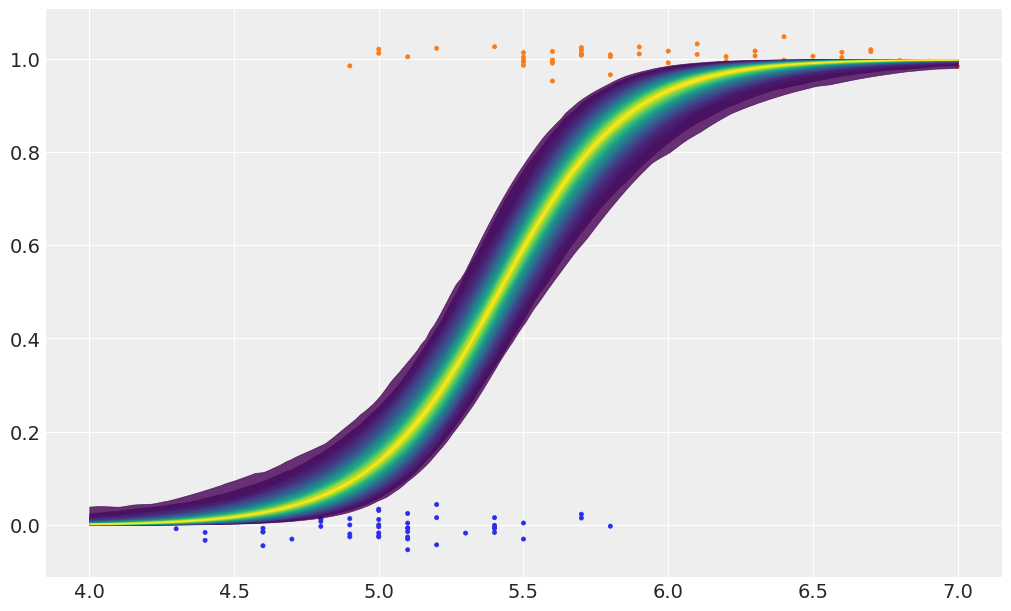

In [20]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
_, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])
pm.gp.util.plot_gp_dist(ax, fp, X_new[:, 0], palette='viridis', plot_samples=False);

现在，图7.12看起来比图7.11更类似于图4.4。 此示例有两个主要目标：

展示如何轻松组合内核以获得更具表现力的模型

展示如何使用高斯过程恢复逻辑回归

关于第二点，逻辑回归确实是高斯过程的一种特殊情况，因为简单的线性回归只是高斯过程的一种特殊情况。 实际上，许多已知的模型可以看作是GP的特例，或者至少它们以某种方式与GP相连。 您可以从Kevin Murphy的《机器学习：概率论》中阅读第15章以获取详细信息。

在实践中，使用GP建模可以通过逻辑回归解决的问题没有太大意义。 取而代之的是，我们希望使用GP来建模较复杂的数据，而这些数据不能用较灵活的模型很好地捕获。 例如，假设我们要根据年龄对疾病的可能性进行建模。 事实证明，非常年轻和非常老的人比中年人有更高的风险。 数据集space_flu.csv是一个受先前描述启发的假数据集。 让我们加载它：

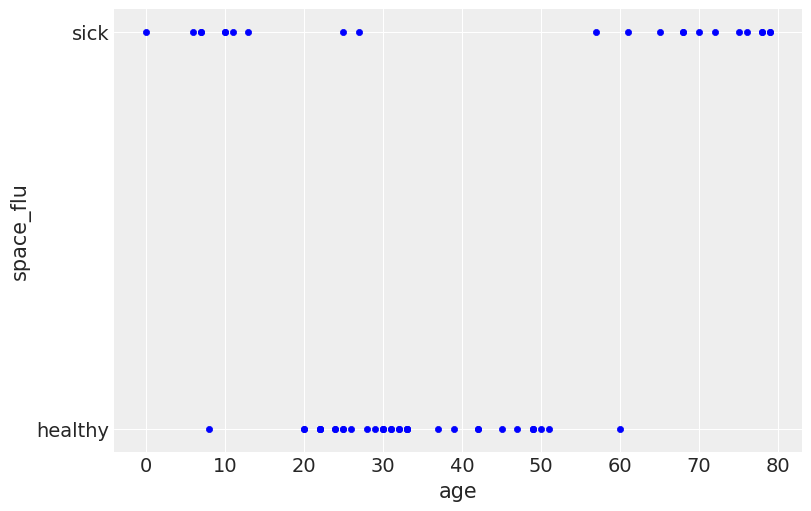

In [21]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
plt.savefig('B11197_07_13.png', bbox_inches='tight')

In [22]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    trace_space_flu = pm.sample(
        1000, chains=1, compute_convergence_checks=False,cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 128 seconds.


In [23]:
X_new = np.linspace(0, 80, 200)[:, None]

with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples2 = pm.sample_posterior_predictive(trace_space_flu,
                                                  vars=[f_pred],
                                                  samples=1000)

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


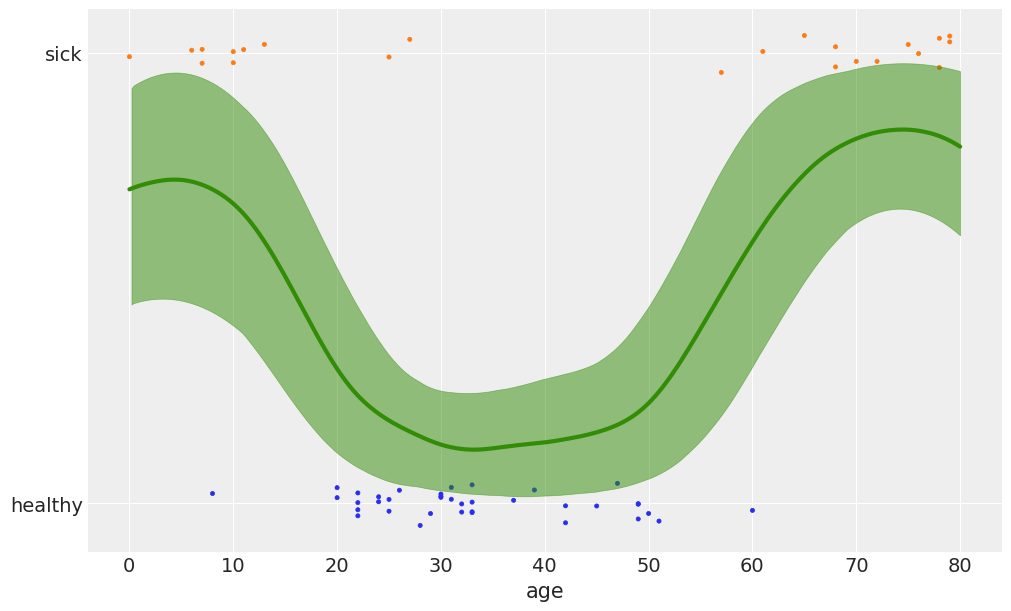

In [24]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples2['f_pred'])
fp_mean = np.nanmean(fp, 0)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hpd(X_new[:, 0], fp, color='C2',ax=ax)
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')
plt.savefig('B11197_07_14.png')

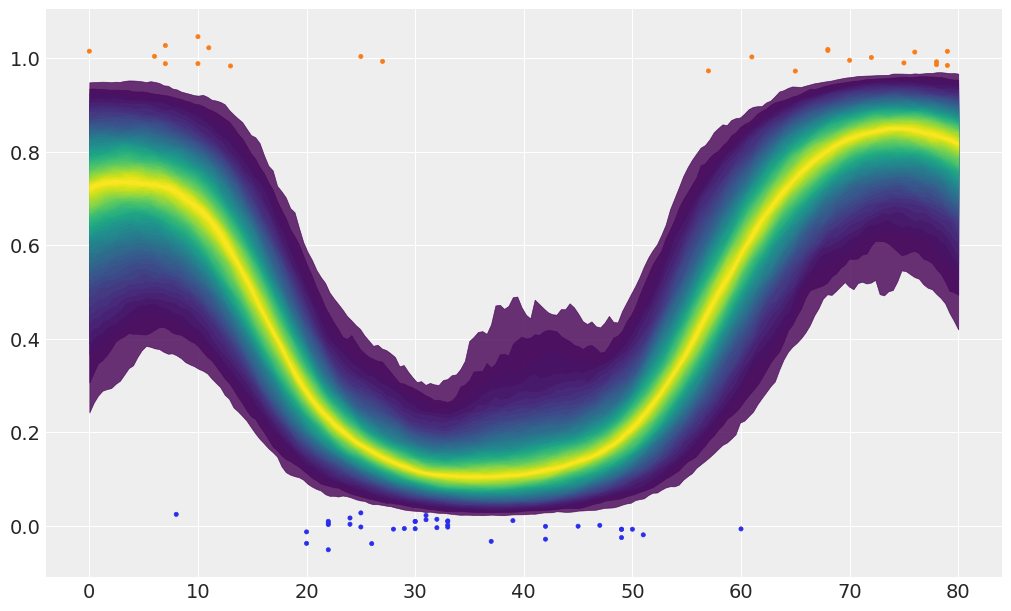

In [25]:
_, ax = plt.subplots(figsize=(10, 6))
ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])
pm.gp.util.plot_gp_dist(ax, fp, X_new[:, 0], palette='viridis', plot_samples=False);

请注意，如图7.14所示，即使数据要求函数比逻辑函数复杂，GP也能很好地拟合该数据集。 除非我们引入一些临时的修改以帮助它一点点，否则，要进行简单的逻辑回归就不可能很好地拟合此数据（有关此类修改的讨论，请参见练习6）。

## Cox processes
现在回到建模计数数据的示例。 我们将看到两个示例； 一种具有随时间变化的速率，另一种具有2D空间变化的速率。 为了做到这一点，我们将使用泊松似然法，并且将使用高斯过程对速率进行建模。 因为泊松分布的速率限制为正值，所以我们将使用指数作为逆链接函数，就像我们从第4章对零膨胀的泊松回归所做的那样。

在文献中，可变比率也与强度有关。 因此，这种类型的问题称为强度估计。 同样，这种类型的模型通常称为Cox模型。 Cox模型是泊松过程的一种，其速率本身就是随机过程。 正如高斯过程是随机变量的集合（其中这些随机变量的每个有限集合都具有多元正态分布）一样，泊松过程是随机变量的集合（其中这些随机变量的每个有限集合都具有泊松分布）。 我们可以将泊松过程视为给定空间中点集合的分布。 当泊松过程的速率本身是随机过程（例如高斯过程）时，我们就有所谓的考克斯过程。

### the coal-mining disaster
第一个示例称为煤矿灾难示例。 此示例包括1851年至1962年英国的煤矿灾害记录。在此期间，灾害数量被认为受安全法规变化的影响。 我们希望将灾难发生率建模为时间的函数。 我们的数据集由一列组成，每个条目对应于灾难发生的时间。

In [26]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df.head()

0
0  1851.2026
1  1851.6324
2  1851.9692
3  1851.9747
4  1852.3142

如您所见，这是一个泊松回归问题。 在这一点上，您可能想知道，如果只有一列仅包含灾难发生日期的列，那么我们将如何执行回归分析。 答案是将数据离散化，就像在构建直方图一样。 我们将使用bin的中心作为变量x，使用每个bin的计数作为变量y：

In [33]:
x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2

array([1853.25847222, 1857.37021667, 1861.48196111, 1865.59370556,
       1869.70545   , 1873.81719444, 1877.92893889, 1882.04068333,
       1886.15242778, 1890.26417222, 1894.37591667, 1898.48766111,
       1902.59940556, 1906.71115   , 1910.82289444, 1914.93463889,
       1919.04638333, 1923.15812778, 1927.26987222, 1931.38161667,
       1935.49336111, 1939.60510556, 1943.71685   , 1947.82859444,
       1951.94033889, 1956.05208333, 1960.16382778])

In [27]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year  每年的事故数
y_data = hist / 4             

In [19]:
np.histogram(coal_df, bins=27)

(array([14, 11, 13, 12, 18, 10, 17, 14, 10,  8,  7,  1,  2,  7,  5,  3,  1,
         3,  2,  8,  6,  7,  3,  5,  1,  1,  2], dtype=int64),
 array([1851.2026    , 1855.31434444, 1859.42608889, 1863.53783333,
        1867.64957778, 1871.76132222, 1875.87306667, 1879.98481111,
        1884.09655556, 1888.2083    , 1892.32004444, 1896.43178889,
        1900.54353333, 1904.65527778, 1908.76702222, 1912.87876667,
        1916.99051111, 1921.10225556, 1925.214     , 1929.32574444,
        1933.43748889, 1937.54923333, 1941.66097778, 1945.77272222,
        1949.88446667, 1953.99621111, 1958.10795556, 1962.2197    ]))

In [28]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    trace_coal = pm.sample(1000, chains=1,cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 125 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\utils.py:654: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\stats\stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


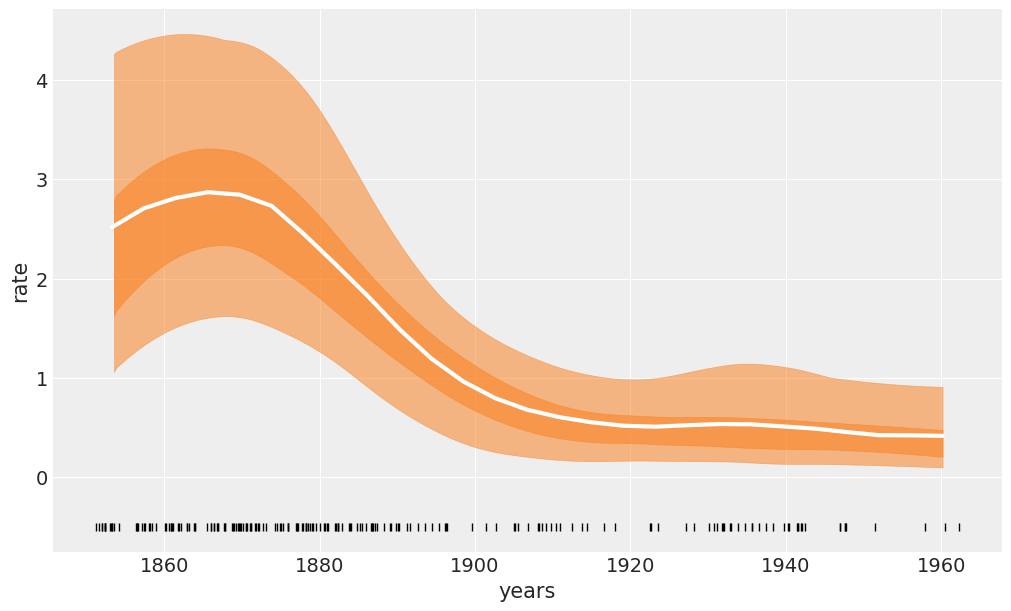

In [30]:
_, ax = plt.subplots(figsize=(10, 6))

f_trace = np.exp(trace_coal['f'])
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hpd(x_centers, f_trace,ax=ax)

az.plot_hpd(x_centers, f_trace, credible_interval=0.5,
            plot_kwargs={'alpha': 0},ax=ax)

ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')
plt.savefig('B11197_07_15.png')

图7.15用白线显示了中位数灾难率与时间的关系。 条带描述了50％HPD间隔（较暗）和94％HPD间隔（较亮）。 在底部，每个灾难都有黑色标记（有时被称为地毯图）。 我们可以看到，事故发生率随时间而下降，除了最初的短暂增加。 PyMC3文档包括煤矿开采灾难，但从不同角度进行了建模。 我强烈建议您检查该示例，因为它本身非常有用，并且将其与我们刚刚使用model_coal模型实现的方法进行比较也很有用。https://docs.pymc.io/notebooks/getting_started.html?highlight=coal%20mining%20disaster

with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)
    
请注意，即使对数据进行装箱，也可以得到平滑的曲线。 从这个意义上讲，我们可以看到model_coal（通常是这种类型的模型）正在构建直方图，然后对其进行平滑处理。

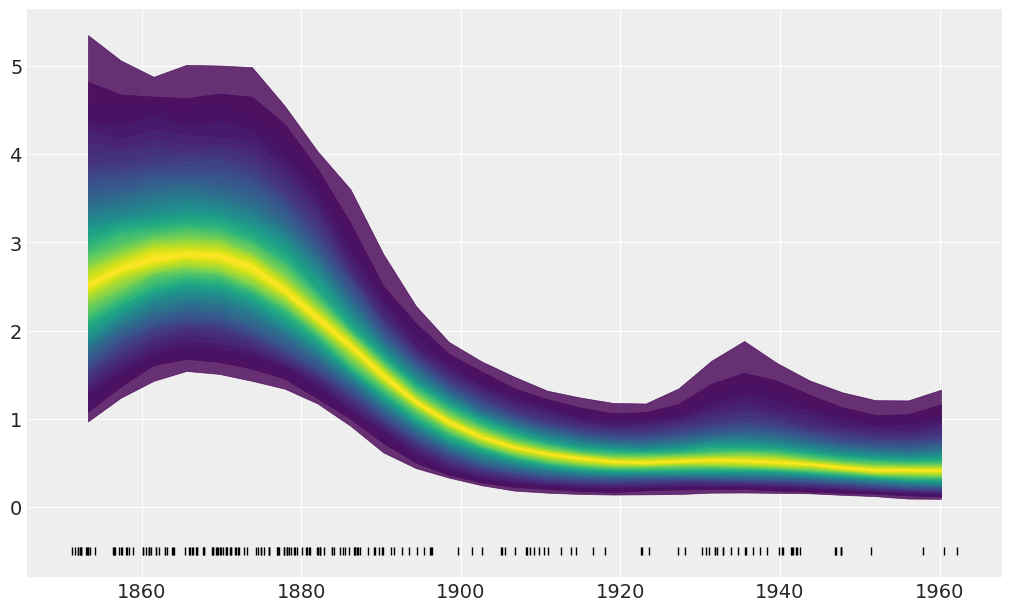

In [34]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
pm.gp.util.plot_gp_dist(ax, f_trace, x_centers, palette='viridis', plot_samples=False);

### the redwood data
现在，我们将集中精力使用红木数据，将与刚才处理的相同类型的模型应用于二维空间问题。 我从GPstuff软件包（用于Matlab，Octave和R的高斯过程软件包）中获取了此数据集（随GPL许可证分发）。该数据集由给定区域上的红木树的位置组成。 推断的动机是确定树木的速率在该区域的分布方式。

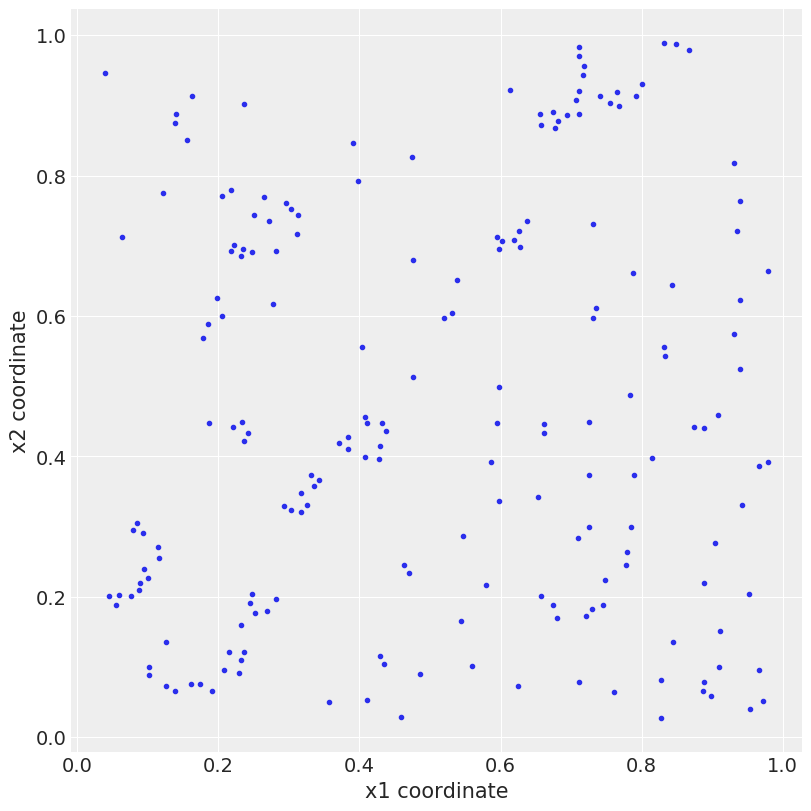

In [35]:
rw_df = pd.read_csv('../data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')
plt.savefig('B11197_07_16.png')

In [114]:
rw_df.std().values

array([0.28075337, 0.28956177])

In [110]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

注意，我们将x1和x2数据视为分开的，而不是进行网格划分。 这使我们能够为每个坐标建立协方差矩阵，从而有效地减少了计算GP所需的矩阵大小。 使用LatentKron类定义GP时，我们只需要注意。 重要的是要注意，这不是数字技巧，而是这种类型矩阵结构的数学属性，因此我们在模型中没有引入任何近似或误差。 我们只是以更快的计算速度来表达它：

In [115]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ',  rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])

    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)

    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    trace_rw = pm.sample(1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [f_rotated_, ℓ]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 1500/1500 [00:40<00:00, 36.

In [116]:
az.summary(trace_rw, var_names=['ℓ'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
ℓ[0]  0.131  0.039   0.080    0.207      0.003    0.002     146.0   139.0   
ℓ[1]  0.096  0.028   0.052    0.140      0.002    0.001     196.0   196.0   

      ess_bulk  ess_tail  r_hat  
ℓ[0]     196.0     165.0   1.01  
ℓ[1]     209.0     369.0   1.01

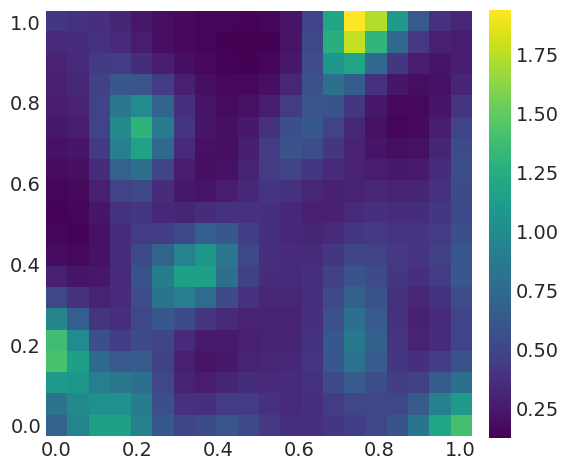

In [117]:
rate = np.exp(np.mean(trace_rw['f'], axis=0).reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)
plt.savefig('B11197_07_17.png')

在图7.17中，较浅的颜色表示比较深的颜色具有更高的树木比率。 我们可能会想象我们对寻找高生长率区域感兴趣，因为我们可能对木材如何从火中恢复感兴趣，或者我们对土壤的特性感兴趣，并且我们使用树木作为替代。

## 总结
高斯过程是多元高斯分布到无穷多个维度的概括，并由均值函数和协方差函数完全指定。由于我们可以在概念上将函数视为无限长的向量，因此我们可以将高斯过程用作函数的先验。实际上，我们不使用无限对象，而是使用维数与数据点一样多的多元高斯分布。为了定义它们相应的协方差函数，我们使用了参数正确的内核。通过了解这些超参数，我们最终了解了任意复杂的函数。
在本章中，我们简要介绍了GP。我们已经介绍了回归，半参数模型（孤岛示例），结合了两个或多个内核以更好地描述未知函数，以及如何将GP用于分类任务。还有许多其他话题需要讨论。尽管如此，我希望对GP的介绍能激发您足够的动力，让您继续使用，阅读和学习高斯过程和非参数模型。

## 练习
For the example in the Covariance functions and kernels section make
sure you understand the relationship between the input data and the
generated covariance matrix. Try using other input such as data =
np. random. normal(size=4)

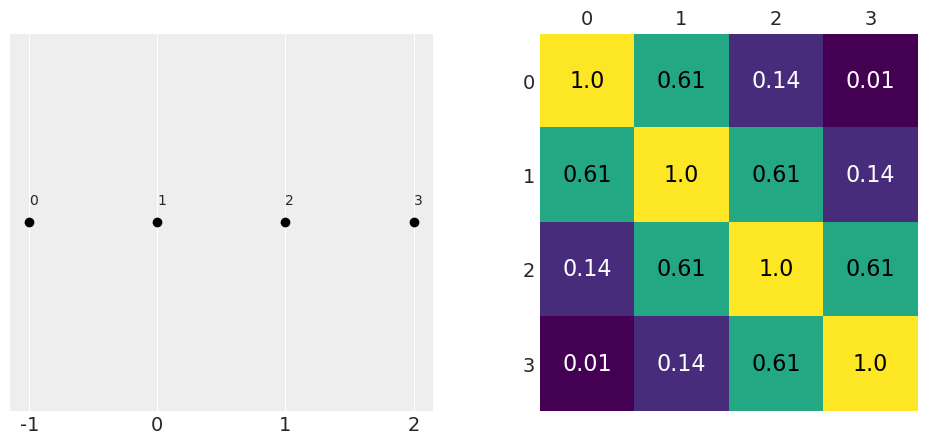

In [120]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])


data = np.array([-1, 0, 1, 2])

def plot_covariance(data):
    """Functionalize the code block from the chapter to try different data"""
    cov = exp_quad_kernel(data, data, 1)

    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax = np.ravel(ax)

    ax[0].plot(data, np.zeros_like(data), 'ko')
    ax[0].set_yticks([])
    for idx, i in enumerate(data):
        ax[0].text(i, 0+0.005, idx)
    ax[0].set_xticks(data)
    ax[0].set_xticklabels(np.round(data, 2))
    #ax[0].set_xticklabels(np.round(data, 2), rotation=70)

    ax[1].grid(False)
    im = ax[1].imshow(cov)
    colors = ['w', 'k']
    for i in range(len(cov)):
        for j in range(len(cov)):
            ax[1].text(j, i, round(cov[i, j], 2),
                       color=colors[int(im.norm(cov[i, j]) > 0.5)],   #在使用cmap映射到颜色之前，用于将标量数据缩放到[0，1]范围的Normalize实例。 
                       #默认情况下，使用线性比例将最小值映射到0，将最大值映射到1。 对于RGB（A）数据，将忽略此参数。
                       ha='center', va='center', fontdict={'size': 16})
    ax[1].set_xticks(range(len(data)))
    ax[1].set_yticks(range(len(data)))
    ax[1].xaxis.tick_top()
plot_covariance(data)

[[1.         0.87434996 0.91250879 0.96143752]
 [0.87434996 1.         0.63916834 0.97212879]
 [0.91250879 0.63916834 1.         0.77810588]
 [0.96143752 0.97212879 0.77810588 1.        ]]


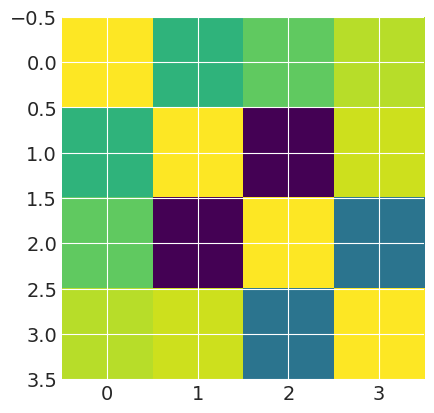

In [149]:
print(cov)
plt.imshow(cov)
#plt.imshow(cov).norm(cov[1, 3]) 

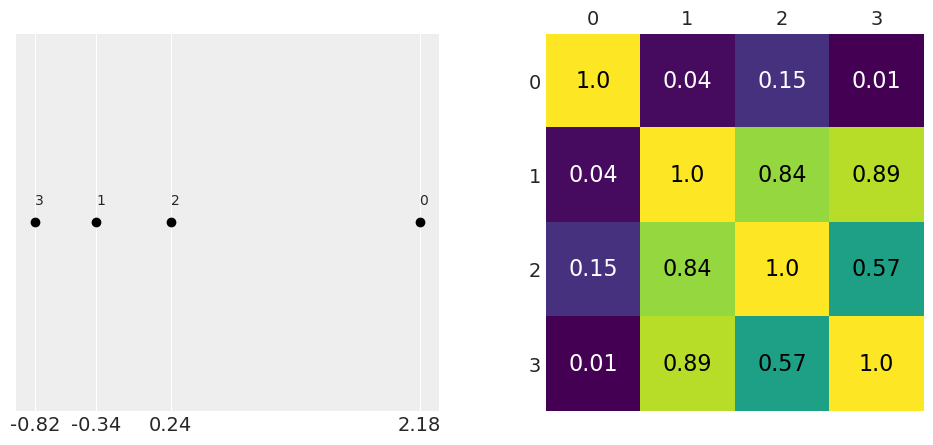

In [122]:
data = np.random.normal(size=4)
plot_covariance(data)  #距离越远相关性越低

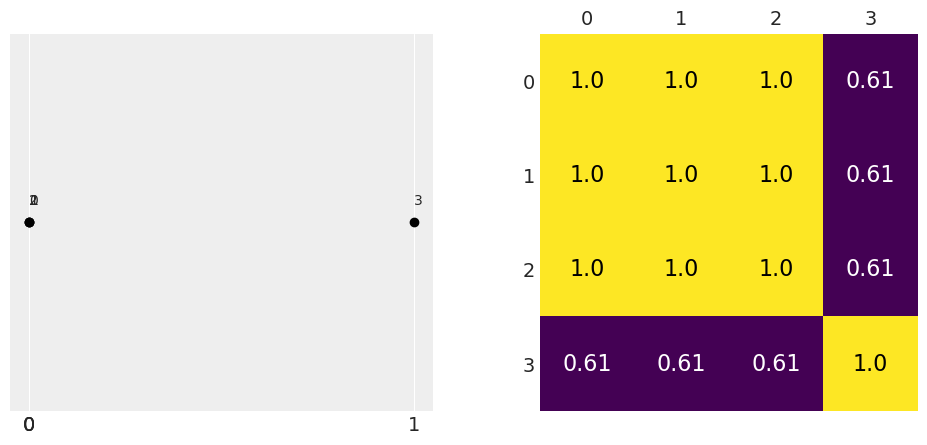

In [123]:
data = np.array([0, 0, 0,1])
plot_covariance(data)

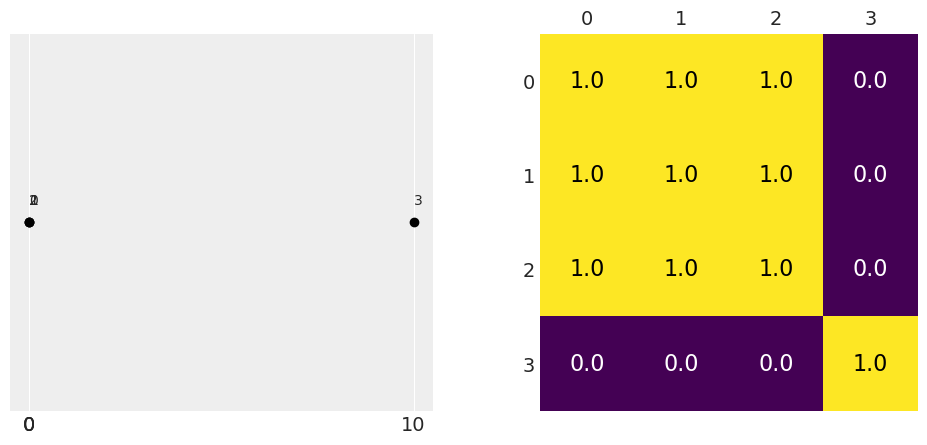

In [124]:
data = np.array([0, 0, 0,10])
plot_covariance(data)

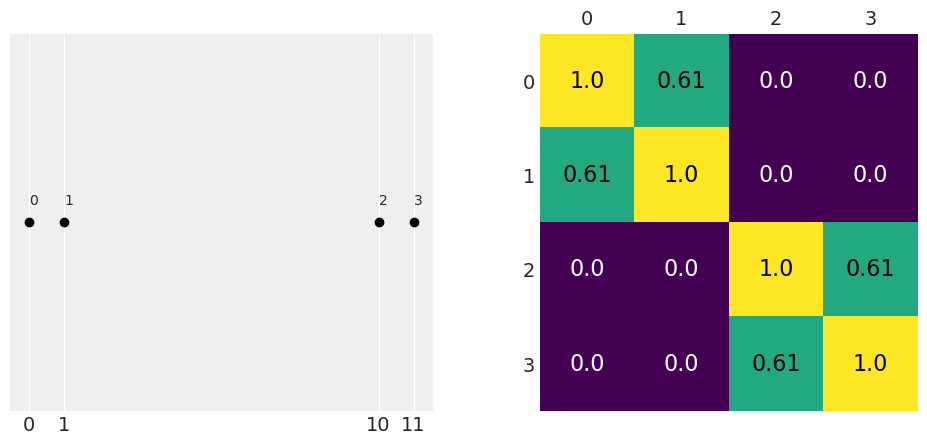

In [144]:
data = np.array([0, 1, 10,11])
plot_covariance(data)

In [126]:
np.exp(-(11-10)**2 / (2*1**2))

0.6065306597126334

Rerun the code generating Figure 7.3 and increase the number of
samples obtained from the GP-prior to around 200. In the original
figure the number of samples is 2. Which is the range of the generated y
values?

In [150]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

Text(-0.03, 0.5, 'f(x)')

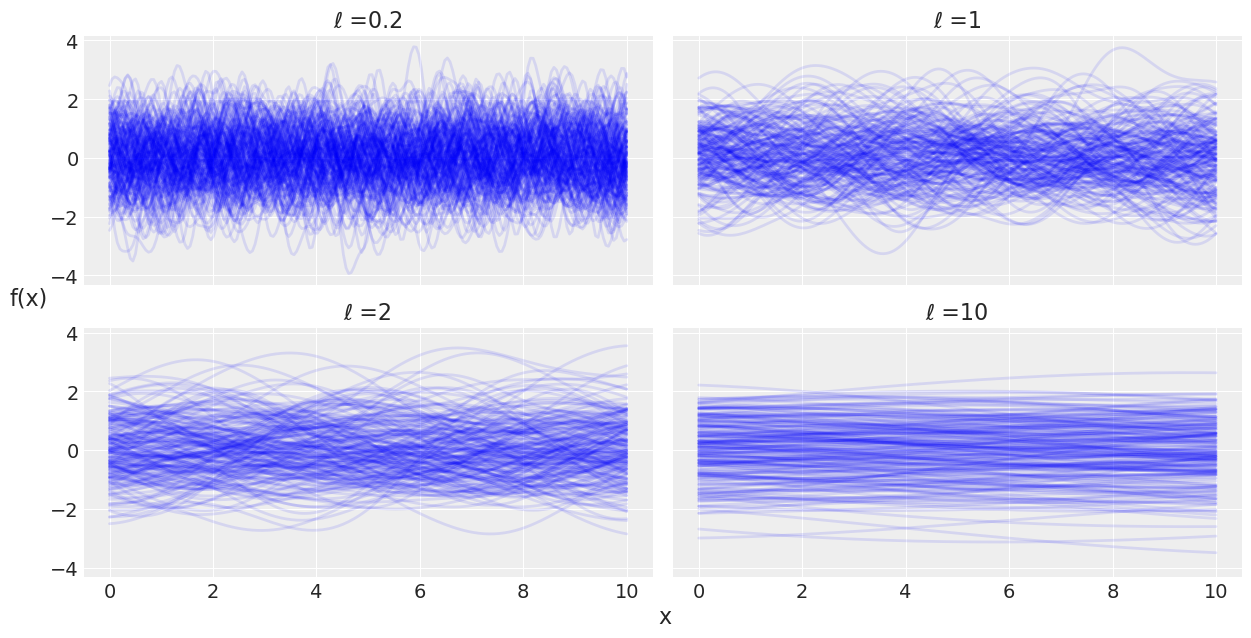

In [151]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    vals = stats.multivariate_normal.rvs(cov=cov, size=200).T
    ax[idx].plot(test_points, vals, alpha=.1, c='b')
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)

斯内核暗含着各种各样的函数，其参数控制着函数的平滑度。ℓ 的值越大，功能越平滑。

3、For the generated plot in the previous exercise. Compute the standard deviation for the values of at each point. Do this in the following form:
Visually, just observing the plots
Directly from the values generated from stats. multivariate_normal. rvs
By inspecting the covariance matrix (if you have doubts go back to exercise 1)
Did the values you get from these 3 methods agree?

In [210]:
cov = exp_quad_kernel(test_points, test_points, 10)
vals = stats.multivariate_normal.rvs(cov=cov, size=1000)

In [211]:
np.var(vals.T[0,:])  #First we'll calculate the variance of all y values at X=0 to see that we get a variance of 1

1.008239891730369

In [160]:
cov[0][0]

1.0

最后，在视觉上检查该图，看起来y值的范围通常在-3到3之间。我们可以模拟高斯分布，方差为1，以再次检查范围的估计。

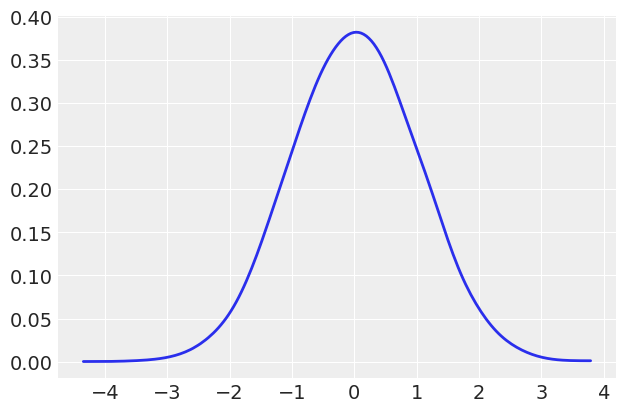

In [161]:
az.plot_kde(stats.norm(0, scale=np.sqrt(1)).rvs(10000))

4、Re-run the model model_reg and get new plots but using as
test_points X_new np. linspace(np. floor(x. min() ) , 20, 100) [: , None] . What did
you observed? How is this related to the specification of the GP-prior?

重新运行模型model_reg并获取新图，但将其用作test_points X_new np. linspace(np. floor(x. min() ) , 20, 100) [: , None]。 你观察到了什么？ 这与GP先验的规范有何关系？

In [220]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    trace_reg = pm.sample(2000,cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, ℓ]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:07<00:00, 316.38it/s]
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [221]:
az.summary(trace_reg)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
ℓ  1.376  0.340   0.761    2.016      0.008    0.006    1898.0  1898.0   
ϵ  0.156  0.058   0.073    0.260      0.001    0.001    2009.0  1659.0   

   ess_bulk  ess_tail  r_hat  
ℓ    1851.0    1840.0    1.0  
ϵ    2327.0    2102.0    1.0

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: User

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F76F7FF28>,
      dtype=object)

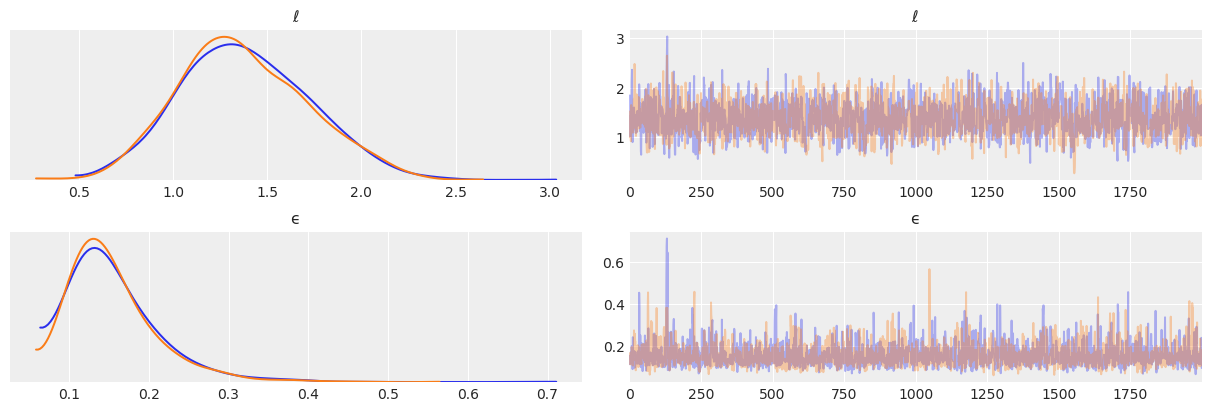

In [222]:
az.plot_trace(trace_reg)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:37<00:00, 107.18it/s]


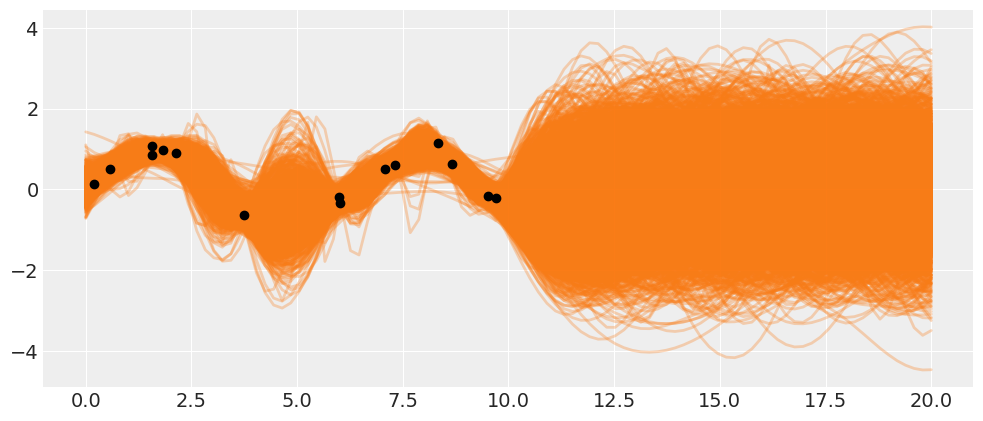

In [223]:
X_new = np.linspace(np.floor(x.min()), 20, 100)[:,None]

with model_reg:
    # conditional distribution evaluated over new input locations
    f_pred = gp.conditional("f_pred", X_new)
    # samples from the posterior predictive distribution evaluated at the X_new values
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred])

_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples["f_pred"].T, "C1-", alpha=0.3)
ax.plot(X, y, "ko");

5、Go back to exercise 1, but this time use a linear kernel (see the
accompanying code for a linear kernel)

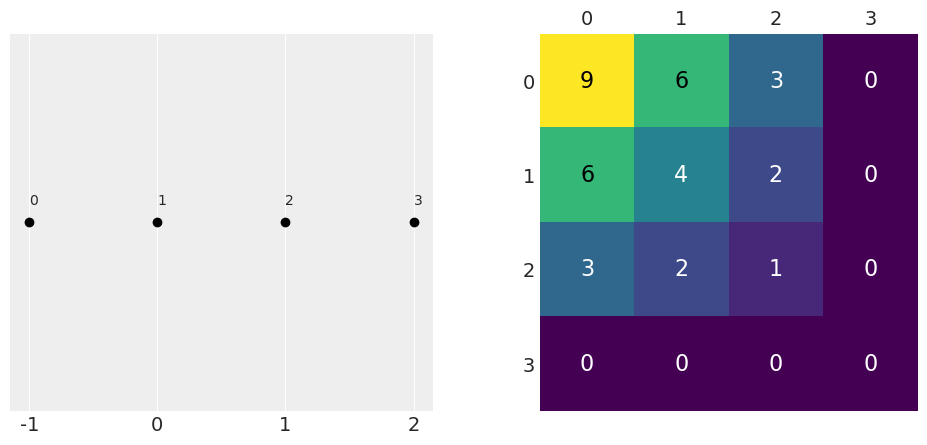

In [225]:
data = np.array([-1, 0, 1, 2])

def linear_kernel(x, knots):
    """ linear kernel """
    return np.array([(x - 2) * (k - 2) for k in knots])

def plot_covariance(data):
    """Functionalize the code block from the chapter to try different data"""
    cov = linear_kernel(data, data)

    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax = np.ravel(ax)

    ax[0].plot(data, np.zeros_like(data), 'ko')
    ax[0].set_yticks([])
    for idx, i in enumerate(data):
        ax[0].text(i, 0+0.005, idx)
    ax[0].set_xticks(data)
    ax[0].set_xticklabels(np.round(data, 2))
    #ax[0].set_xticklabels(np.round(data, 2), rotation=70)

    ax[1].grid(False)
    im = ax[1].imshow(cov)
    colors = ['w', 'k']
    for i in range(len(cov)):
        for j in range(len(cov)):
            ax[1].text(j, i, round(cov[i, j], 2),
                       color=colors[int(im.norm(cov[i, j]) > 0.5)],
                       ha='center', va='center', fontdict={'size': 16})
    ax[1].set_xticks(range(len(data)))
    ax[1].set_yticks(range(len(data)))
    ax[1].xaxis.tick_top()
plot_covariance(data)

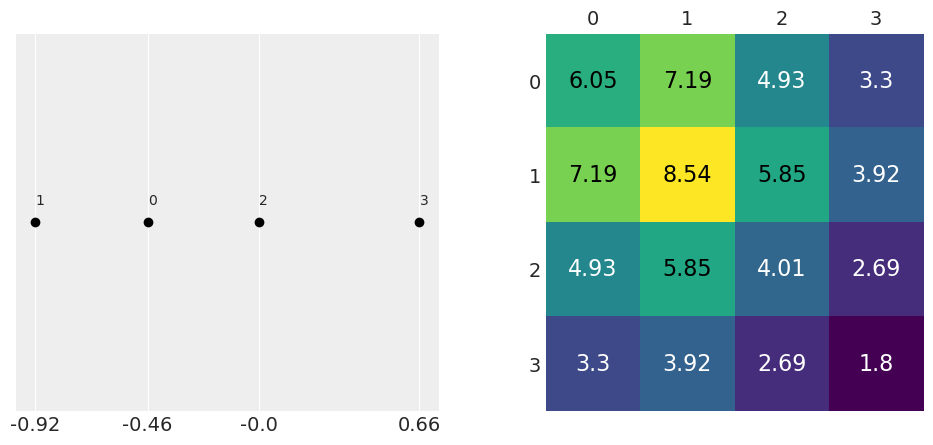

In [226]:
data = np.random.normal(size=4)
plot_covariance(data)

6、Go and check the section https: //docs. pymc. io/notebooks/GP-MeansAndCovs. html from PyMC3' documentation


### Mean and Covariance Functions 均值和协方差函数
PyMC3提供了大量的均值和协方差函数。 定义自定义均值和协方差函数相对容易。 由于PyMC3使用Theano，因此用户无需定义其梯度。

### Mean functions
The following mean functions are available in PyMC3.

gp.mean.Zero

gp.mean.Constant

gp.mean.Linear

全部遵循类似的使用模式。 首先，指定均值函数。 然后可以通过一些输入对其进行评估。 前两个均值函数非常简单。 无论输入内容如何，gp.mean.Zero都会返回零向量，其长度与输入值的数目相同。

#### zero

In [241]:
zero_func = pm.gp.mean.Zero()

X = np.linspace(0, 1, 5)[:, None]
print(zero_func(X).eval())
X

[0. 0. 0. 0. 0.]


array([[0.  ],
       [0.25],
       [0.5 ],
       [0.75],
       [1.  ]])

In [245]:
#只要形状与输入匹配，它将接收gp.mean.Constant也可以接受Theano张量或PyMC3随机变量矢量。
import theano.tensor as tt
np.random.seed(206)
const_func_vec = pm.gp.mean.Constant(tt.ones(5))

print(const_func_vec(X).eval())

[1. 1. 1. 1. 1.]


In [248]:
#gp.mean.Linear是一个系数矩阵和一个截距矢量（或一维斜率和标量截距）的输入。
beta = np.random.randn(3)
b = 0.0

lin_func = pm.gp.mean.Linear(coeffs=beta, intercept=b)

X = np.random.randn(5, 3)
print(lin_func(X).eval())
beta

[ 1.78640367  0.58067605  1.74280368 -2.15244209  1.29580516]


array([-0.16601922, -1.69786769, -0.59599714])

In [250]:
X.dot(beta)+b

array([ 1.78640367,  0.58067605,  1.74280368, -2.15244209,  1.29580516])

### Defining a custom mean function
要定义自定义均值函数，请子类gp.mean.Mean，并提供__call__和__init__方法。 例如，常数均值函数的代码为
#### Remember that Theano must be used instead of NumPy.

In [251]:
import theano.tensor as tt

class Constant(pm.gp.mean.Mean):

    def __init__(self, c=0):
        Mean.__init__(self)
        self.c = c

    def __call__(self, X):
        return tt.alloc(1.0, X.shape[0]) * self.c

### Covariance functions¶
PyMC3包含更大的内置协方差函数套件。 下面显示了从具有给定协方差函数的GP之前提取的函数，并演示了如何使用Python运算符以简单的方式构造复合协方差函数。 我们的目标是使我们的API尽可能接近内核代数（请参阅Rassmussen + Williams的第4章）。 有关在PyMC3中的用法概述，请参见主要文档页面。
#### Exponentiated Quadratic 指数二次方

$k(x,x′)=exp[−\frac{(x−x′)^2}{2ℓ^2}]$

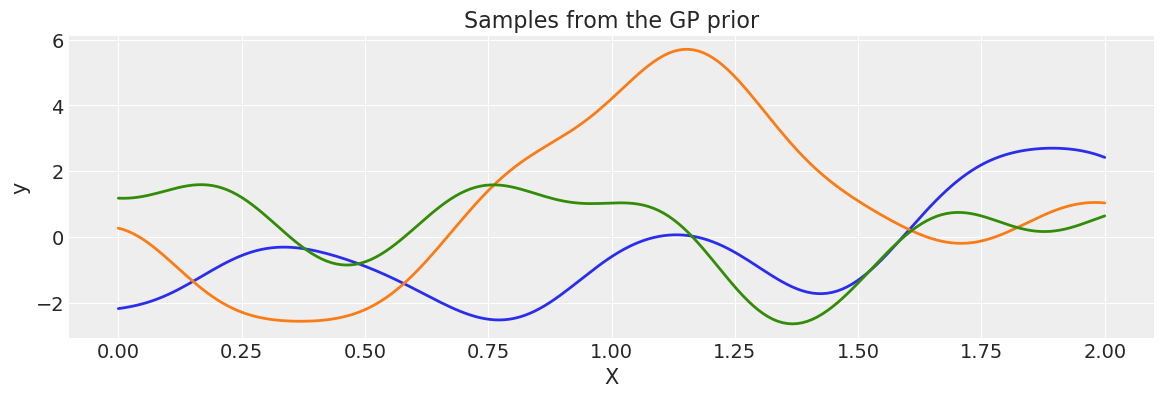

In [257]:
lengthscale = 0.2
eta = 2.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Two (and higher) Dimensional Inputs
#### Both dimensions active 
定义具有较高维输入的内核很容易。 请注意，ls（长度标度）参数是长度2的数组。PyMC3随机变量列表可用于自动相关性确定（ARD）。

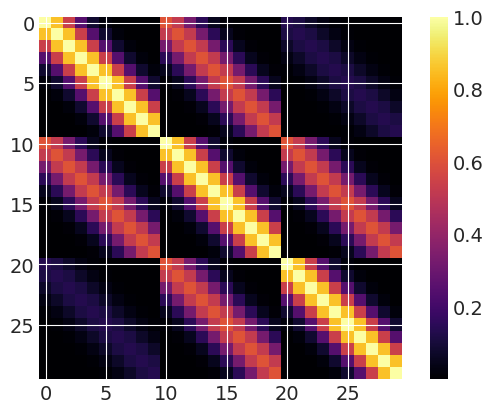

In [263]:
import theano
x1, x2 = np.meshgrid(np.linspace(0,1,10), np.arange(1,4))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)

ls = np.array([0.2, 1.0])
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

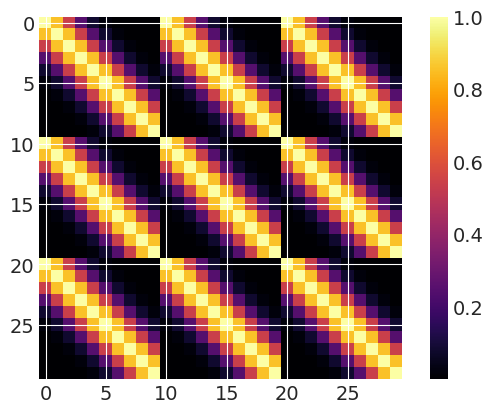

In [260]:
## One dimension active
ls = 0.2
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls, active_dims=[0])

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

#### Product of covariances over different dimensions¶
请注意，这等效于为每个维度使用带有单独的长度比例参数的二维ExpQuad。 等同于2维激活的

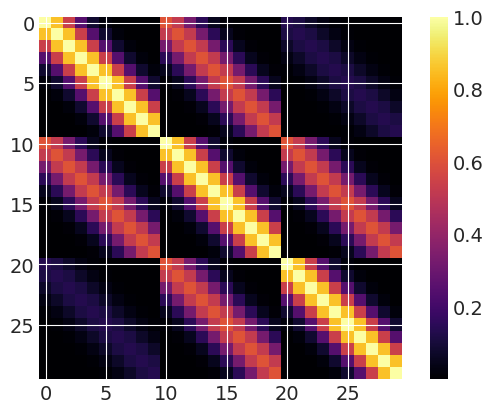

In [261]:
ls1 = 0.2
ls2 = 1.0
cov1 = pm.gp.cov.ExpQuad(2, ls1, active_dims=[0])
cov2 = pm.gp.cov.ExpQuad(2, ls2, active_dims=[1])
cov = cov1 * cov2

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

### White Noise¶
$k(x,x′)=σ^2I_{xx}$

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


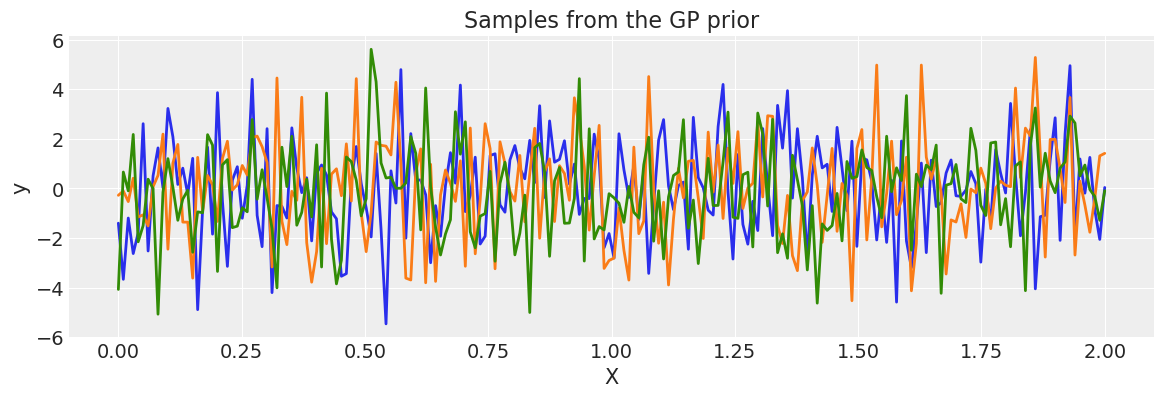

In [265]:
sigma = 2.0
cov = pm.gp.cov.WhiteNoise(sigma)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Constant
$k(x,x′)=c$

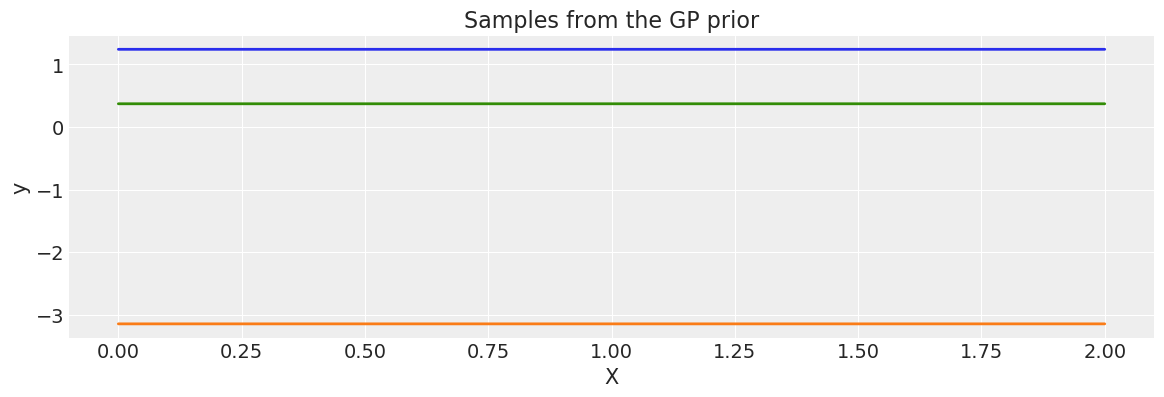

In [267]:
c = 2.0
cov = pm.gp.cov.Constant(c)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Rational Quadratic 有理二次方
$k(x,x′)=(1+\frac{(x−x′)^2}{2αℓ^2})^{−α}$

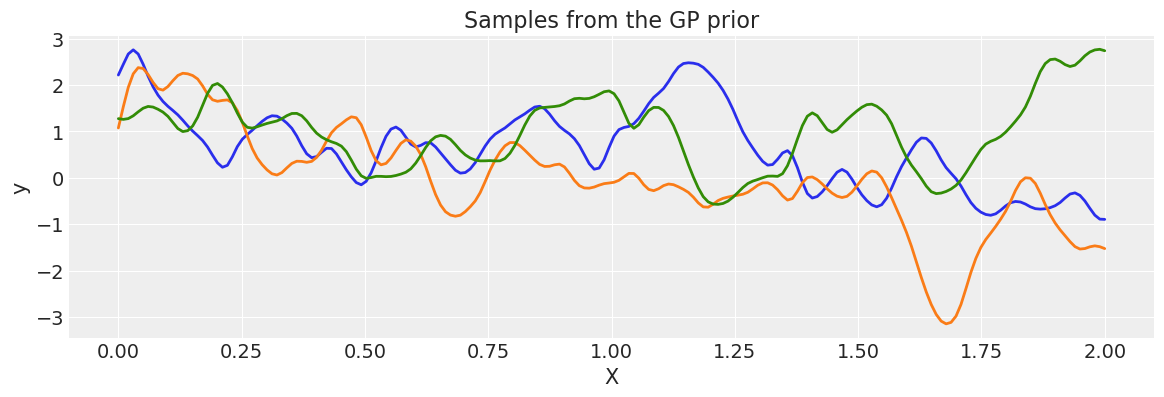

In [268]:
alpha = 0.1
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.RatQuad(1, ls, alpha)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Exponential¶
$k(x,x′)=exp[−\frac{||x−x′||}{2ℓ^2}]$

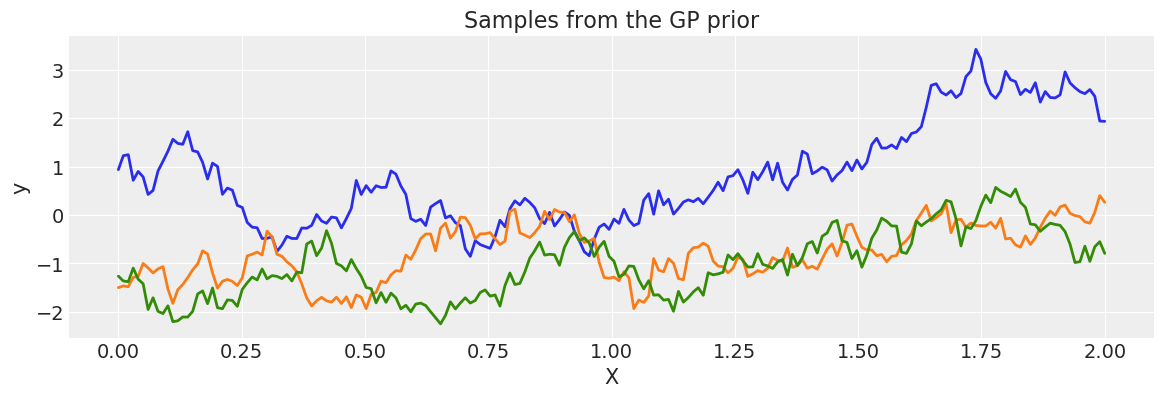

In [269]:
inverse_lengthscale = 5
cov = pm.gp.cov.Exponential(1, ls_inv=inverse_lengthscale)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Matern 5/2¶

![title](7_5.png)

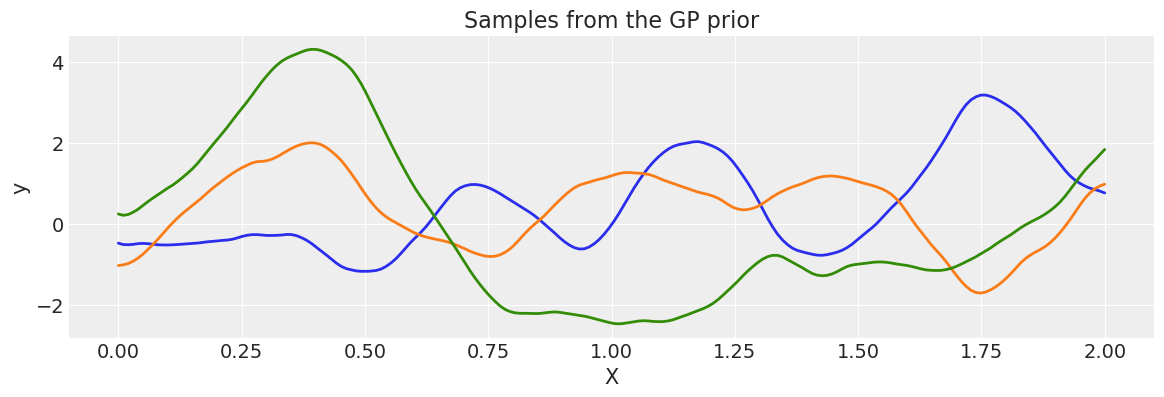

In [270]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern52(1, ls)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

Matern 3/2¶

![title](7_6.png)

Text(0.5, 0, 'X')

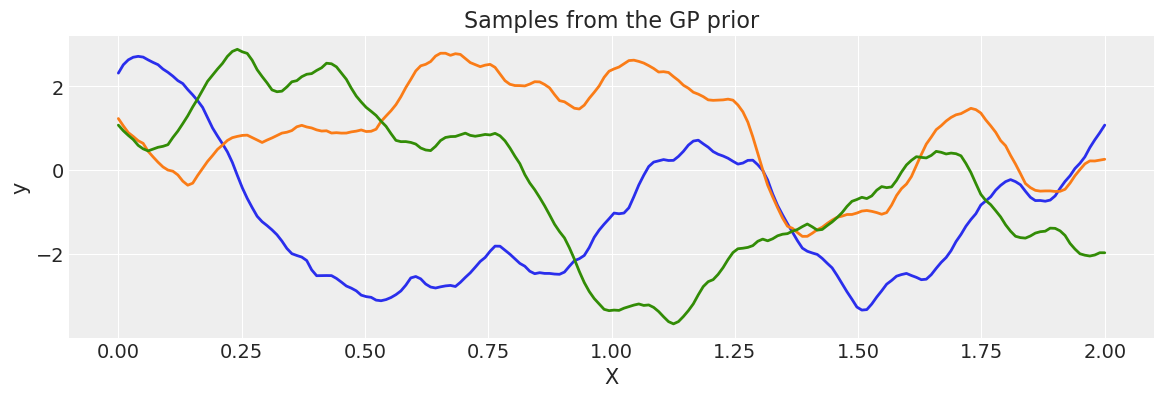

In [271]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern32(1, ls)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X")

Cosine
$k(x,x′)=cos(2π\frac{||x−x′||}{ℓ^2})$

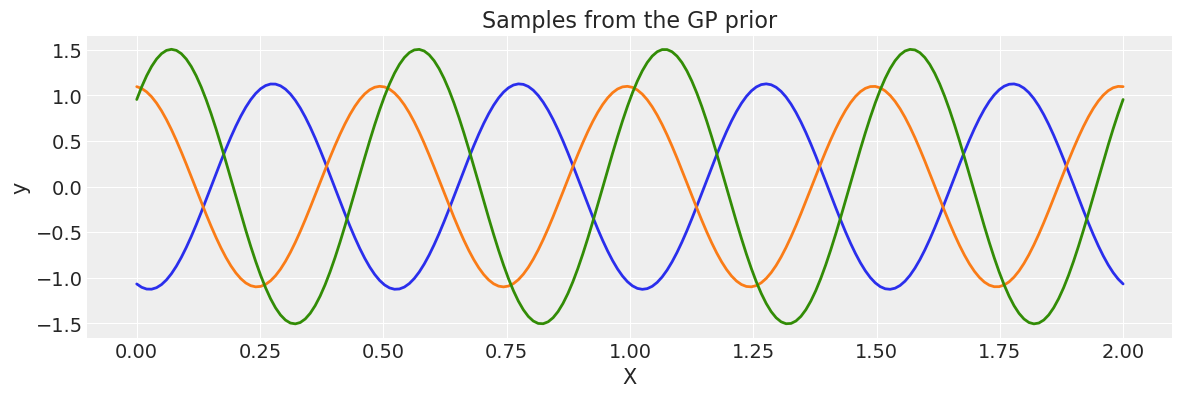

In [272]:
period = 0.5
cov = pm.gp.cov.Cosine(1, period)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

Linear¶
k(x,x′)=(x−c)(x′−c)

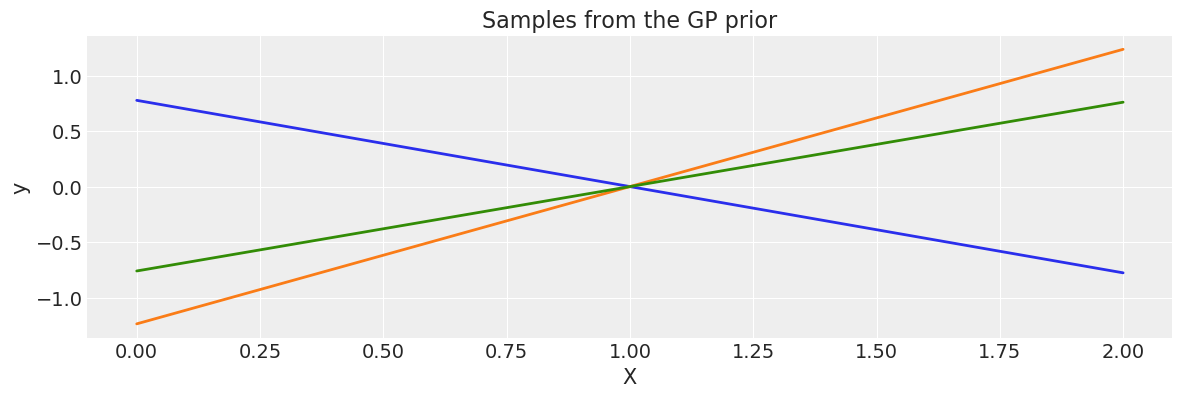

In [274]:
c = 1.0
tau = 2.0
cov = tau * pm.gp.cov.Linear(1, c)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

Polynomial¶ 多项式
$k(x,x′)=[(x−c)(x′−c)+offset]^d$

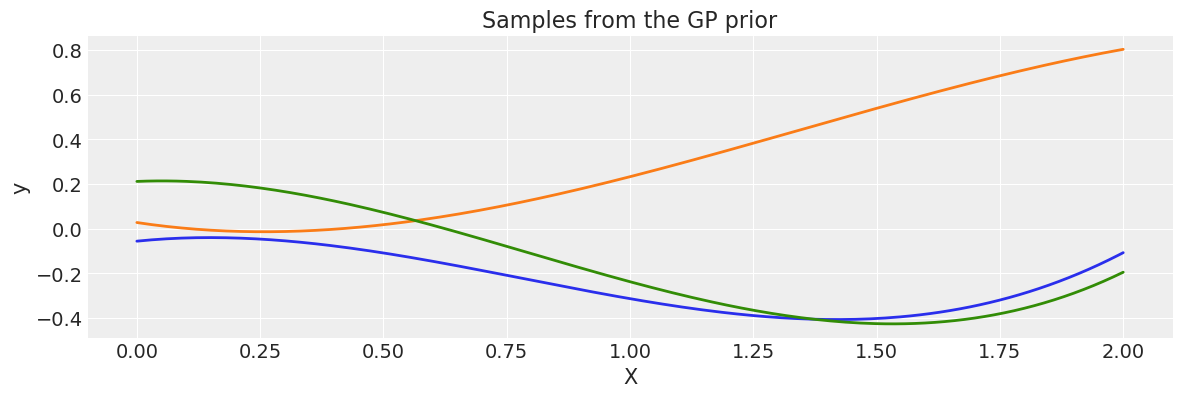

In [275]:
c = 1.0
d = 3
offset = 1.0
tau = 0.1
cov = tau * pm.gp.cov.Polynomial(1, c=c, d=d, offset=offset)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Multiplication with a precomputed covariance matrix¶ 与预先计算的协方差矩阵相乘
只要形状合适，可以将协方差函数cov与numpy矩阵K_cos相乘。

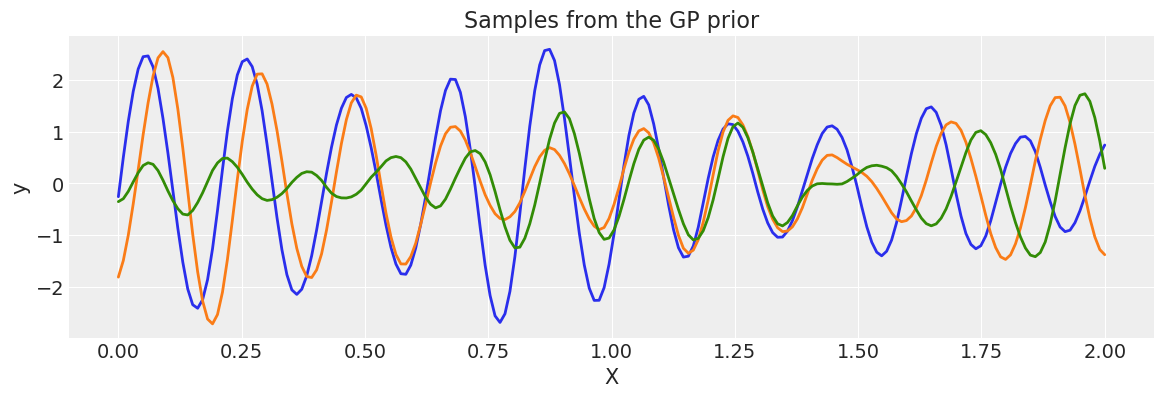

In [277]:
# first evaluate a covariance function into a matrix
period = 0.2
cov_cos = pm.gp.cov.Cosine(1, period)
K_cos = theano.function([], cov_cos(X))()

# now multiply it with a covariance *function*
cov = pm.gp.cov.Matern32(1, 0.5) * K_cos

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Applying an arbitary warping function on the inputs 在输入上应用任意变形函数
如果k（x，x'）是有效的协方差函数，则k（w（x），w（x'））也是。

翘曲函数的第一个参数必须是输入X。其余参数可以是其他任何参数，包括随机变量。

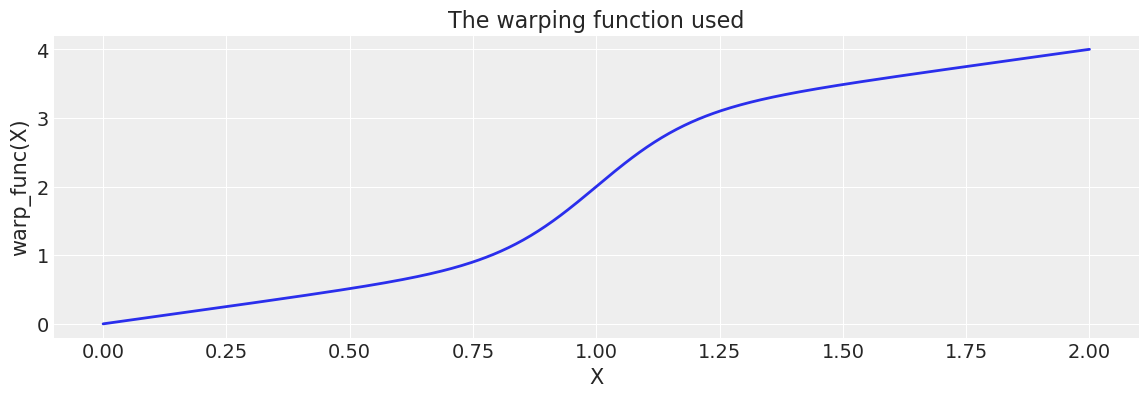

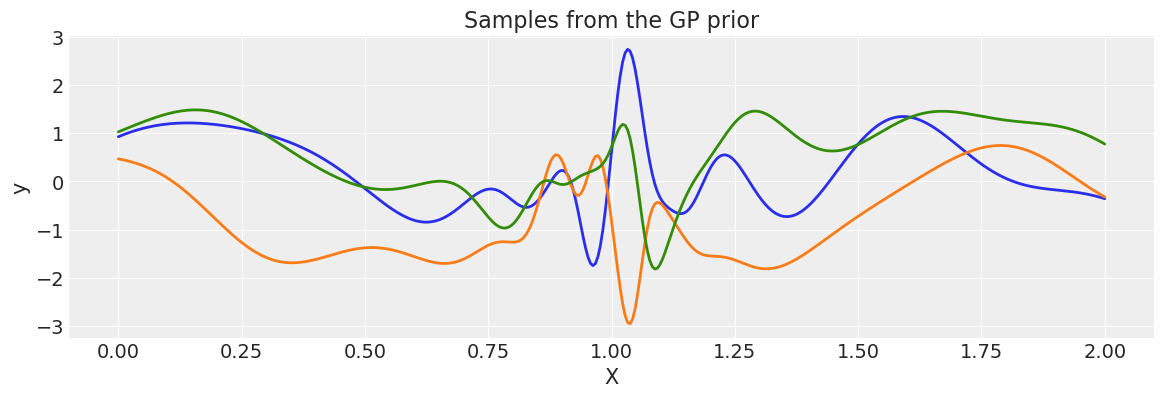

In [278]:
def warp_func(x, a, b, c):
    return 1.0 + x + (a * tt.tanh(b * (x - c)))

a = 1.0
b = 5.0
c = 1.0

cov_exp = pm.gp.cov.ExpQuad(1, 0.2)
cov = pm.gp.cov.WarpedInput(1, warp_func=warp_func, args=(a,b,c), cov_func=cov_exp)

X = np.linspace(0, 2, 400)[:,None]
wf = warp_func(X.flatten(), a,b,c).eval()

plt.figure(figsize=(14,4))
plt.plot(X, wf); plt.xlabel("X"); plt.ylabel("warp_func(X)");
plt.title("The warping function used");

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Constructing Periodic using WarpedInput 使用WarpedInput构造周期
WarpedInput内核可用于创建周期协方差。 此协方差可建模具有周期性但不是精确的正弦波的函数（就像余弦内核一样）。

周期核由下式给出

![title](7_7.png)

其中T是周期，ℓ是长度标尺。 可以通过使功能为u（x）=（sin（2πx1T），cos（2πx1T））的ExpQuad内核的输入变形来得出。 在这里，我们使用WarpedInput内核来构造它。

在页面顶部定义的输入X为2个“秒”长。 我们使用的周期为0.5，这意味着从该GP先前提取的函数将在2秒钟内重复4次。

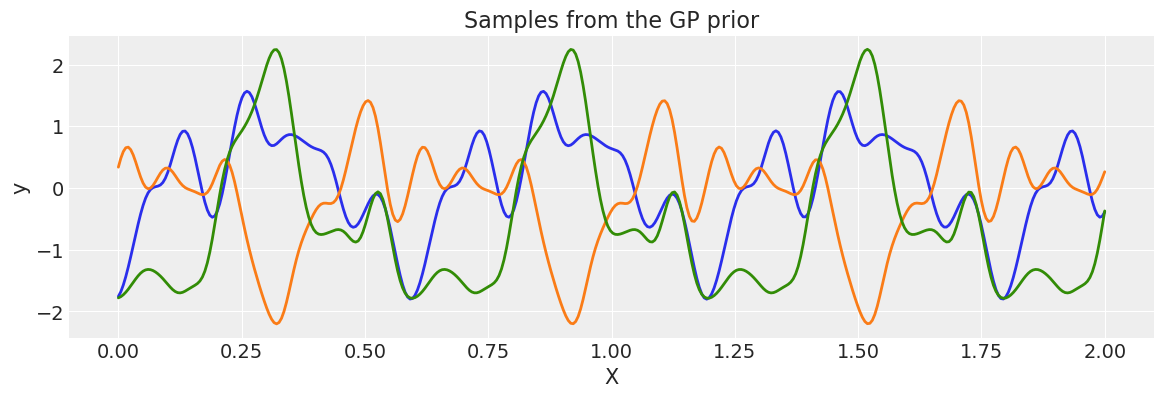

In [279]:
def mapping(x, T):
    c = 2.0 * np.pi * (1.0 / T)
    u = tt.concatenate((tt.sin(c*x), tt.cos(c*x)), 1)
    return u

T = 0.6   #重复周期是0.6秒
ls = 0.4
# note that the input of the covariance function taking
#    the inputs is 2 dimensional
cov_exp = pm.gp.cov.ExpQuad(2, ls)
cov = pm.gp.cov.WarpedInput(1, cov_func=cov_exp,
                               warp_func=mapping, args=(T, ))

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

In [ ]:
Periodic 定期的
无需每次都以此方式构造周期协方差。 内置了此协方差函数的更有效实现。

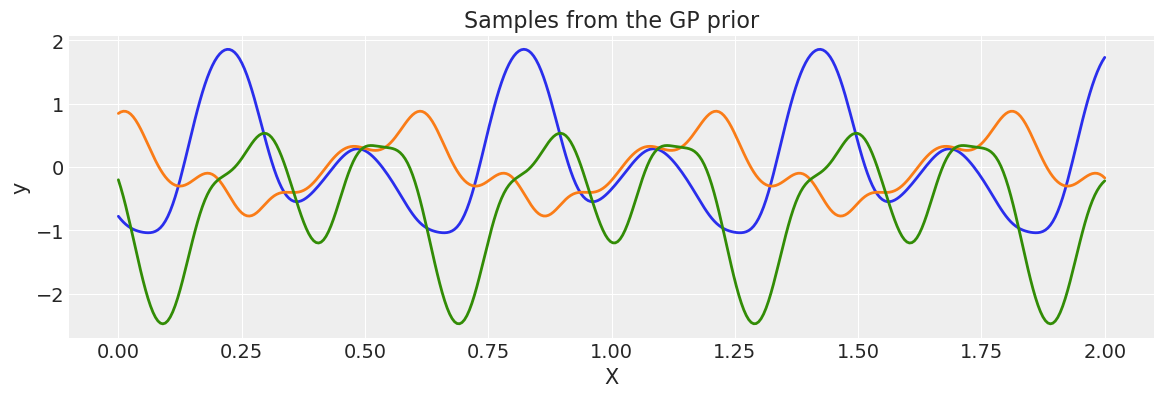

In [280]:
period = 0.6
ls = 0.4
cov = pm.gp.cov.Periodic(1, period=period, ls=ls)

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

Gibbs¶
Gibbs协方差函数将正定翘曲函数应用于长度尺度。 与WarpedInput相似，可以使用固定或随机变量的参数来指定lengthscale变形函数。

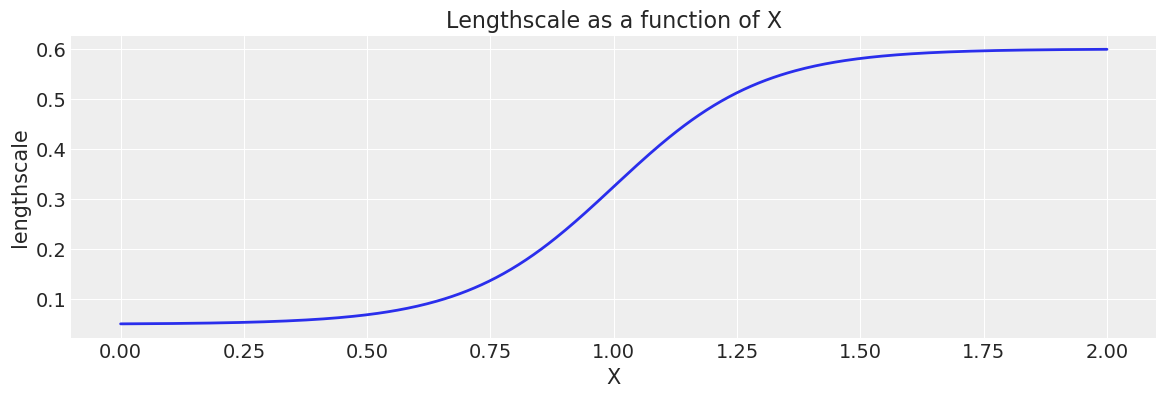

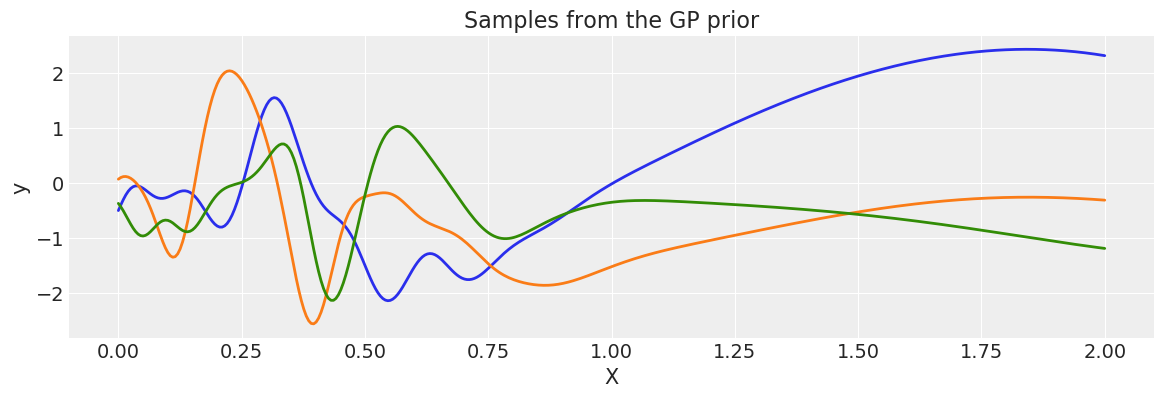

In [281]:
def tanh_func(x, ls1, ls2, w, x0):
    """
    ls1: left saturation value
    ls2: right saturation value
    w:   transition width
    x0:  transition location.
    """
    return (ls1 + ls2) / 2.0 - (ls1 - ls2) / 2.0 * tt.tanh((x - x0) / w)

ls1 = 0.05
ls2 = 0.6
w = 0.3
x0 = 1.0
cov = pm.gp.cov.Gibbs(1, tanh_func, args=(ls1, ls2, w, x0))

wf = tanh_func(X, ls1, ls2, w, x0).eval()
plt.figure(figsize=(14,4))
plt.plot(X, wf); plt.ylabel("lengthscale"); plt.xlabel("X"); plt.title("Lengthscale as a function of X");

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

Scaled Covariance 比例协方差
可以通过将基本核乘以非负函数ϕ（x）来构造新的核或协方差函数，
$k_{scaled}(x,x′)=ϕ(x)k_{base}(x,x′)ϕ(x′).$

这对于指定幅度在整个域中变化的协方差函数很有用。

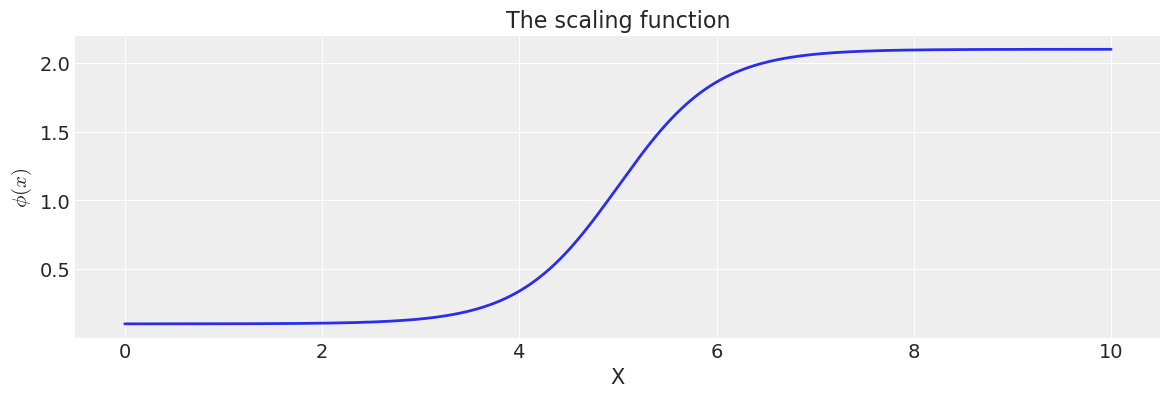

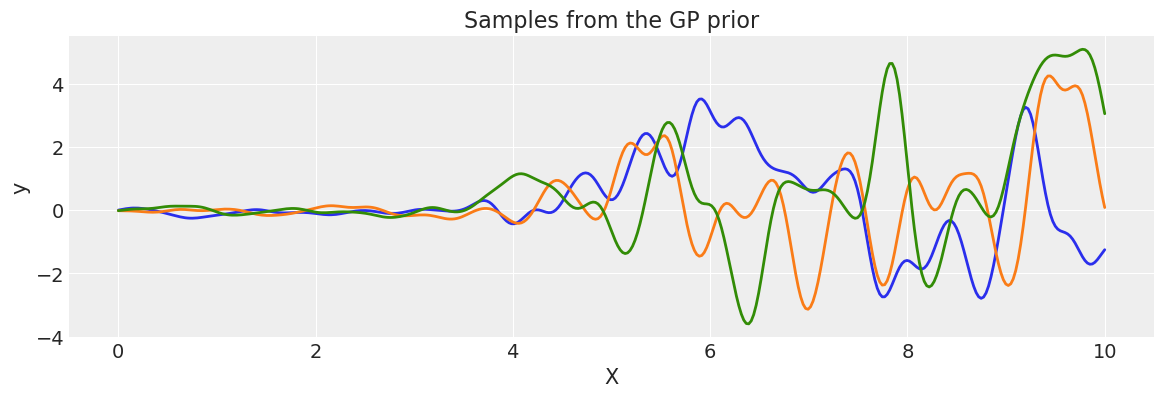

In [282]:
def logistic(x, a, x0, c, d):
    # a is the slope, x0 is the location
    return d * pm.math.invlogit(a*(x - x0)) + c


a = 2.0
x0 = 5.0
c = 0.1
d = 2.0

cov_base = pm.gp.cov.ExpQuad(1, 0.2)
cov = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(a,x0,c,d), cov_func=cov_base)

X = np.linspace(0, 10, 400)[:,None]
lfunc = logistic(X.flatten(), a, b, c, d).eval()

plt.figure(figsize=(14,4))
plt.plot(X, lfunc); plt.xlabel("X"); plt.ylabel("$\phi(x)$");
plt.title("The scaling function");

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

Constructing a Changepoint kernel using ScaledCov¶ 使用ScaledCov构造一个Changepoint内核

ScaledCov内核可用于创建Changepoint协方差。 这种协方差模型化了一个从一种行为逐渐过渡到另一种行为的过程。

变更点内核由

k(x,x′)=ϕ(x)k1(x,x′)ϕ(x)+(1−ϕ(x))k2(x,x′)(1−ϕ(x′))

where ϕ(x) is the logistic function.

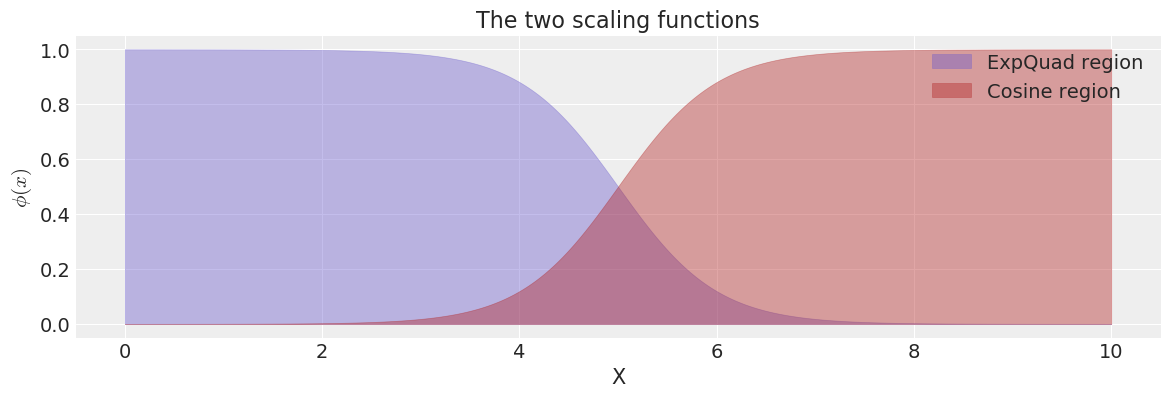

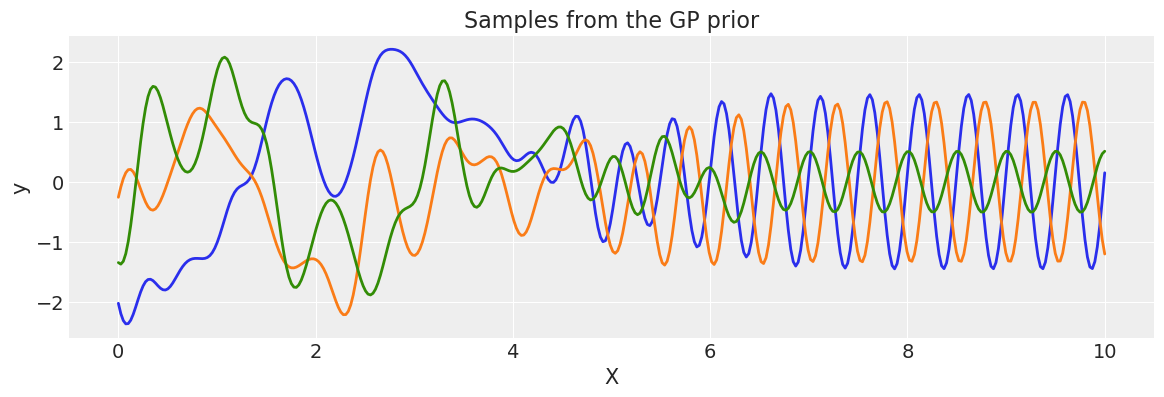

In [283]:
def logistic(x, a, x0):
    # a is the slope, x0 is the location
    return pm.math.invlogit(a*(x - x0))


a = 2.0
x0 = 5.0

cov1 = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(-a, x0),
                           cov_func=pm.gp.cov.ExpQuad(1, 0.2))
cov2 = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(a, x0),
                           cov_func=pm.gp.cov.Cosine(1, 0.5))
cov = cov1 + cov2

X = np.linspace(0, 10, 400)
plt.figure(figsize=(14,4))
plt.fill_between(X, np.zeros(400), logistic(X, -a, x0).eval(), label="ExpQuad region",
                 color="slateblue", alpha=0.4);
plt.fill_between(X, np.zeros(400), logistic(X,  a, x0).eval(), label="Cosine region",
                 color="firebrick", alpha=0.4);
plt.legend();
plt.xlabel("X"); plt.ylabel("$\phi(x)$");
plt.title("The two scaling functions");

K = cov(X[:,None]).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

Defining a custom covariance function¶ 定义自定义协方差函数
PyMC3中的协方差函数对象需要实现__init __，diag和full方法以及子类gp.cov.Covariance.diag仅返回协方差矩阵的对角线，而full返回完整的协方差矩阵。 完整方法有两个输入X和Xs。 full（X）返回平方协方差矩阵，full（X，Xs）返回两组输入之间的互协方差。

For example, here is the implementation of the WhiteNoise covariance function:

In [284]:
class WhiteNoise(pm.gp.cov.Covariance):
    def __init__(self, sigma):
        super(WhiteNoise, self).__init__(1, None)
        self.sigma = sigma

    def diag(self, X):
        return tt.alloc(tt.square(self.sigma), X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return tt.diag(self.diag(X))
        else:
            return tt.alloc(0.0, X.shape[0], Xs.shape[0])

7、Run a logistic regression model for the space_flu data. What do you see?
Can you explain the result?

In [229]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values
space_flu = df_sf.space_flu.values

In [232]:
# Linear Model
with pm.Model() as space_flu_model:
    α = pm.Normal("α", 0,1)
    β = pm.Normal("β", 0,1)
    
    μ = α + pm.math.dot(age, β)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    
    bd = pm.Deterministic('bd', -α/β)
    
    y = pm.Bernoulli("y", p=θ, observed=space_flu)
    flu_logistic_trace = pm.sample(4000,cores=1,chains=1, compute_convergence_checks=False)  #跑双链出问题了
    flu_logistic_samples  = pm.sample_posterior_predictive(flu_logistic_trace, vars=[θ,y], samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [β, α]
Sampling chain 0, 0 divergences: 100%|████████████████████████████████████████████| 4500/4500 [00:05<00:00, 818.99it/s]
C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 806.66it/s]


Text(0, 0.5, 'θ')

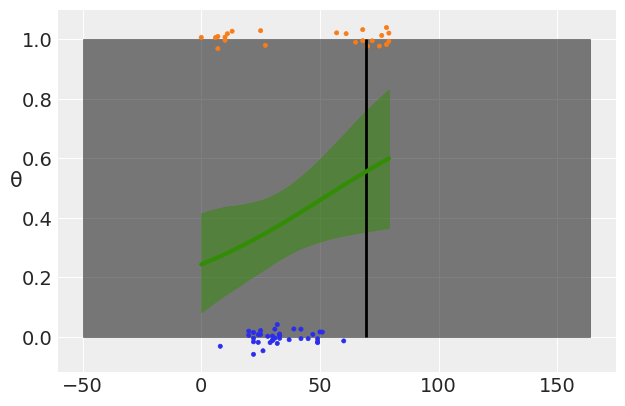

In [233]:
# Plot decision boundary
plt.vlines(flu_logistic_trace['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(flu_logistic_trace['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

# Plot observed value
plt.scatter(age, np.random.normal(space_flu, 0.02), marker='.', color=[f'C{x}' for x in space_flu])

# Plot mean of parameter estimate
theta = flu_logistic_trace['θ'].mean(axis=0)
idx = np.argsort(age)
plt.plot(age[idx], theta[idx], color='C2', lw=3)

# Plot confidence of parameter estimate
az.plot_hpd(age, flu_logistic_trace['θ'], color='C2')

plt.ylabel('θ', rotation=0)

果然简单的模型是无法完成这类数据的模拟的

8、Change the logistic regression model in order to fit the data. Tip, use an order two polynomial.

In [238]:
# Quadratic Model
with pm.Model() as space_flu_model:
    α = pm.Normal("α", 0,1)
    β = pm.Normal("β", 0,1, shape=2)
    
    # Quadratic Parmetarization is in this line
    μ = α + pm.math.dot(age, β[0]) + pm.math.dot(age**2, β[1])
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    
    # bd = pm.Deterministic('bd', -α/β)
    
    y = pm.Bernoulli("y", p=θ, observed=space_flu)
    flu_logistic_trace = pm.sample(4000,cores=1,init="adapt_diag")
    flu_logistic_samples  = pm.sample_posterior_predictive(flu_logistic_trace, vars=[θ,y], samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 4500/4500 [00:11<00:00, 395.06it/s]
The number of effective samples is smaller than 25% for some parameters.
C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 683.49it/s]


Text(0, 0.5, 'θ')

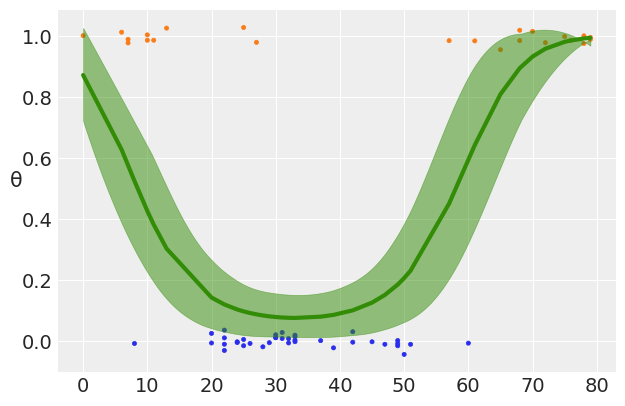

In [239]:
# Plot observed value
plt.scatter(age, np.random.normal(space_flu, 0.02), marker='.', color=[f'C{x}' for x in space_flu])

# Plot mean of parameter estimate
theta = flu_logistic_trace['θ'].mean(axis=0)
idx = np.argsort(age)
plt.plot(age[idx], theta[idx], color='C2', lw=3)

# Plot confidence of parameter estimate
az.plot_hpd(age, flu_logistic_trace['θ'], color='C2')

plt.ylabel('θ', rotation=0)

9、Compare the model for the coal mining disaster with the one from the
PyMC3 documentation ( https: //docs. pymc. io/notebooks/getting_started. html#C
ase-study-2: -Coal-mining-disasters ). Describe the differences between both
models in terms of model-specification and results.

The model in the book and the model from PyMC3 docs answer different questions

PyMC3 docs answer question: When did rate of coal mining diaster change, specifically done by estimating three things, rate prior to change event, and rate post change event, and change event time Book estimates what is rate of coal mining disasters at any point in time. It does not answer the question of when was an event that led to change in rate

PyMC3 Docs回答问题：煤矿灾害的发生率何时改变，具体是通过估算三件事来完成的：更改事件之前的发生率，更改事件之后的发生率以及更改事件的时间

本书估算了任何时间点的煤矿灾害发生率。 它没有回答何时发生导致利率变化的事件